In [1]:
'''
Notebook originally taken and modified from: https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb 
to suit the needs of this project
'''

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, precision_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import CategoricalAccuracy
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

2024-03-19 17:33:30.407337: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load best model

In [2]:
folder = 'pickle'
inner_folder = 'augmented'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]

2024-03-19 17:33:31.975995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 17:33:31.987233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 17:33:31.987476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

# Define helper functions

Function loads and normalises the data

In [3]:
def load_data(num_superpixels):
    data = tf.keras.utils.image_dataset_from_directory(f"Explanations/Validation/{num_superpixels}", image_size=(250, 250))
    data = data.map(lambda image,label: (image/255, label))
    return data

In [4]:
def reset_metrics():
    global acc
    acc = CategoricalAccuracy()

In [5]:
def predict(data):
    global y_one_hot, yhat
    y_true = []
    y_pred = []

    for batch in data.as_numpy_iterator():
        image, y = batch
        y_one_hot = tf.one_hot(y, 21)
        yhat = model.predict(image, verbose=0)
        acc.update_state(y_one_hot, yhat)
        
        y_true.extend(np.argmax(y_one_hot, axis = 1))
        y_pred.extend(np.argmax(yhat, axis = 1))
    return y_true, y_pred

In [6]:
class_labels = [str(i) for i in range(21)]
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]
def create_classification_report(y_true, y_pred):
    print(f'Accuracy:{acc.result().numpy()}')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)

    weighted_avg_precision = precision_score(y_true, y_pred, average='weighted', labels=class_labels)
    
    print("Classification Report:\n", class_report)
    return class_report, weighted_avg_precision

In [7]:
def generate_conf_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
    plt.figure(figsize=(15, 12))
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('True Class', fontsize=20)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    heatmap.tick_params(axis='x', which='major', pad=10)
    heatmap.tick_params(axis='y', which='major', pad=10)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('Number of Samples', fontsize=15, rotation=90, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    plt.show()
    return conf_matrix

In [8]:
def generate_normalised_conf_matrix(conf_matrix):
    class_totals = np.sum(conf_matrix, axis=1)

    normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
    for i in range(len(class_totals)):
        if class_totals[i] != 0:
            normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i] * 100

    plt.figure(figsize=(15, 12))
    heatmap = sns.heatmap(normalised_conf_matrix, annot=True, fmt='.1f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('True Class', fontsize=20)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('% of Samples', fontsize=15, rotation=90, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    plt.show()
    return normalised_conf_matrix

In [9]:
def generate_precision_dict(class_report):
    precision_scores = {class_names[i]: float(class_report.split('\n')[i+2].split()[1]) for i in range(len(class_labels))}
    return precision_scores

## Load all the explanations generated from CreatePerturbations.py

In [10]:
data1 = load_data("1")
data5 = load_data("5")
data15 = load_data("15")
data25 = load_data("25")
data30 = load_data("30")
data35 = load_data("35")
data40 = load_data("40")
data45 = load_data("45")
data_all = load_data("All")


Found 7225 files belonging to 21 classes.
Found 7225 files belonging to 21 classes.
Found 7225 files belonging to 21 classes.
Found 7225 files belonging to 21 classes.
Found 7224 files belonging to 21 classes.
Found 7181 files belonging to 21 classes.
Found 6592 files belonging to 21 classes.
Found 4162 files belonging to 21 classes.
Found 7225 files belonging to 21 classes.


# Metrics for 1 superpixel explanation

In [11]:
reset_metrics()
y_true, y_pred = predict(data1)

2024-03-19 17:33:41.289774: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:33:41.290068: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:33:41.725474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-03-19 17:33:42.452408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
acc_1 = acc
class_report, data1_pre = create_classification_report(y_true, y_pred)  
pre_dict1 = generate_precision_dict(class_report)

Accuracy:0.11404844373464584
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.12      0.94      0.21       826
         BAS       0.00      0.00      0.00        20
         BLA       0.09      0.03      0.05       504
         EBO       0.25      0.00      0.01      1152
         EOS       0.75      0.01      0.02       248
         FGC       0.00      0.00      0.00         3
         HAC       0.00      0.00      0.00        19
         KSC       0.00      0.00      0.00         3
         LYI       0.00      0.00      0.00         4
         LYT       0.28      0.01      0.01      1103
         MMZ       0.10      0.01      0.01       130
         MON       0.00      0.00      0.00       171
         MYB       0.05      0.04      0.05       277
         NGB       0.00      0.00      0.00       420
         NGS       0.33      0.00      0.00      1237
         NIF       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

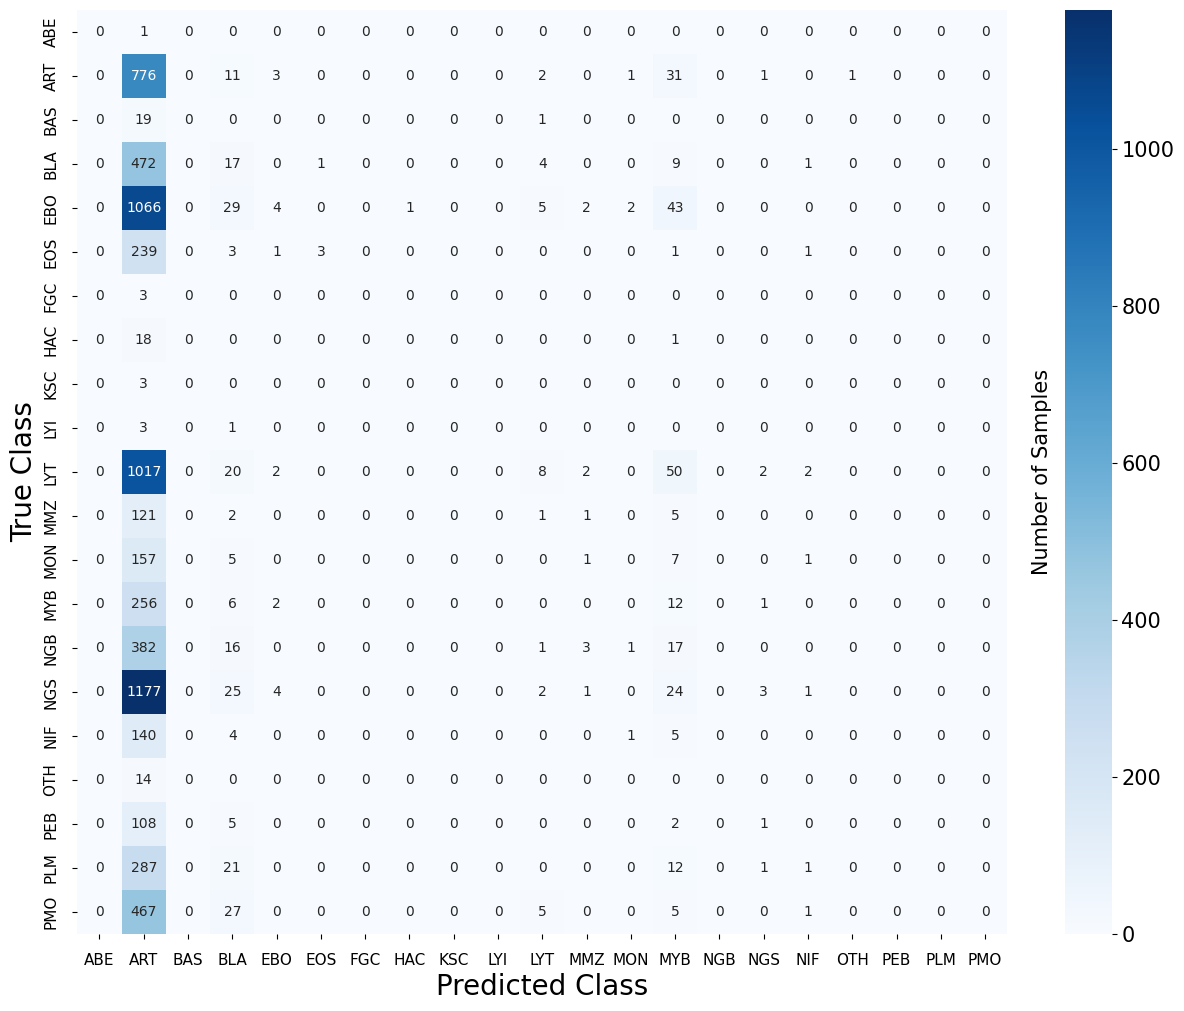

In [13]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

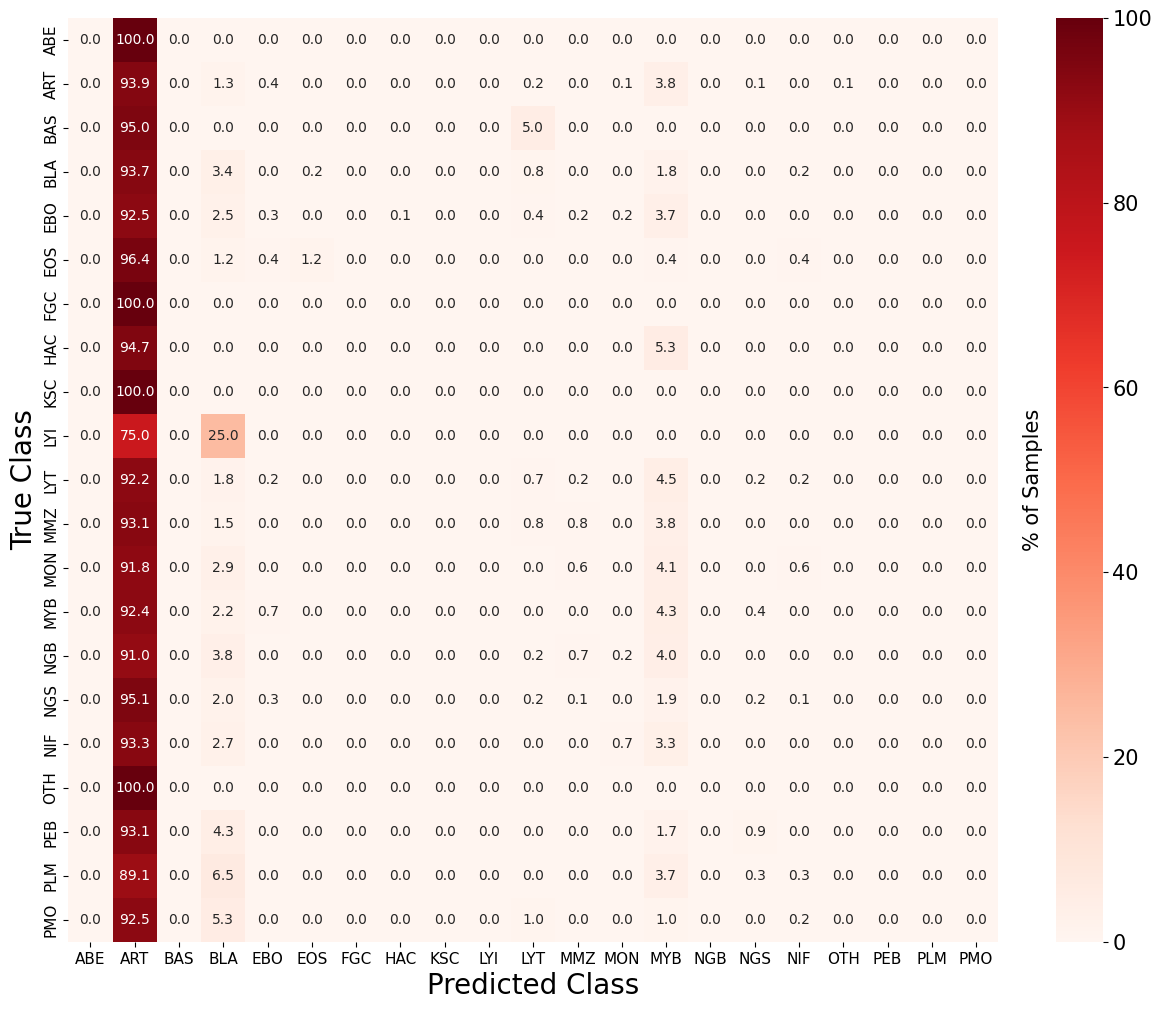

In [14]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 5 superpixel explanation 

In [15]:
reset_metrics()
y_true, y_pred = predict(data5)

2024-03-19 17:34:02.707018: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:34:02.707518: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]


In [16]:
acc_5 = acc
class_report, data5_pre = create_classification_report(y_true, y_pred)
pre_dict5 = generate_precision_dict(class_report)

Accuracy:0.10878892987966537
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.12      0.84      0.21       826
         BAS       0.00      0.00      0.00        20
         BLA       0.07      0.03      0.04       504
         EBO       0.20      0.00      0.01      1152
         EOS       0.71      0.04      0.08       248
         FGC       0.00      0.00      0.00         3
         HAC       0.00      0.00      0.00        19
         KSC       0.00      0.00      0.00         3
         LYI       0.00      0.00      0.00         4
         LYT       0.22      0.02      0.04      1103
         MMZ       0.00      0.00      0.00       130
         MON       0.00      0.00      0.00       171
         MYB       0.03      0.09      0.05       277
         NGB       0.00      0.00      0.00       420
         NGS       0.25      0.01      0.02      1237
         NIF       0.03     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

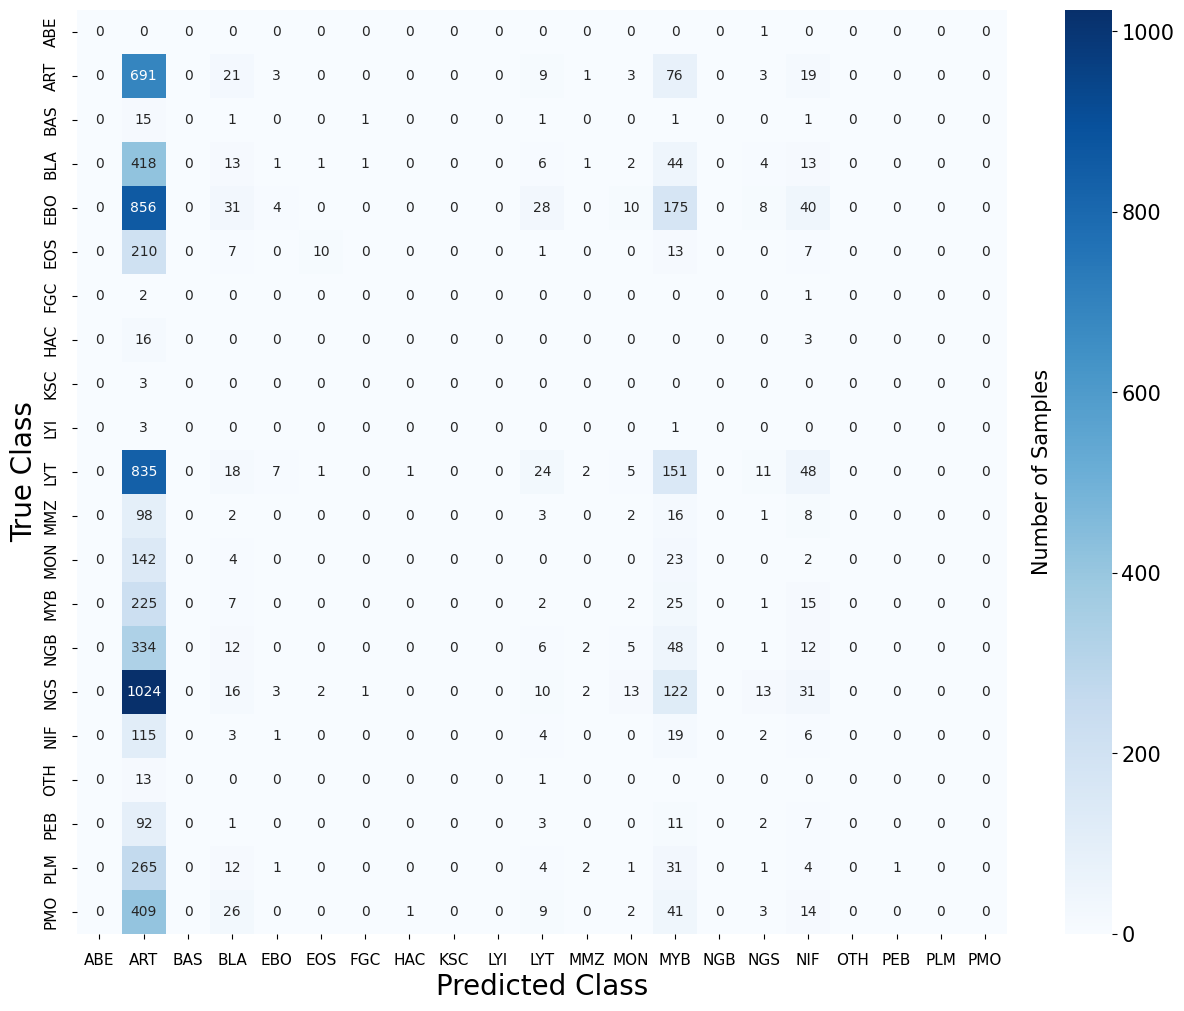

In [17]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

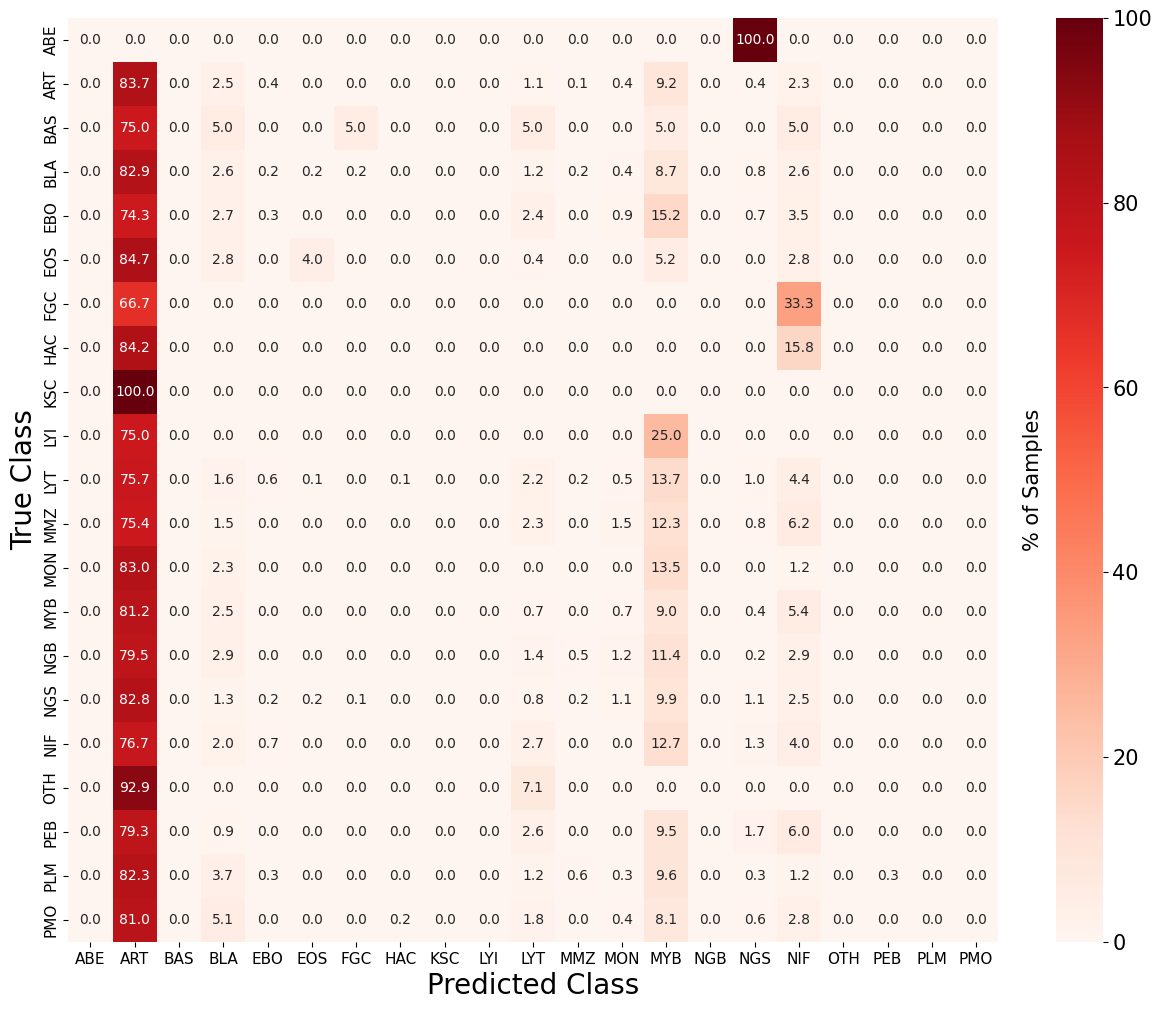

In [18]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 15 superpixel explanation 

In [19]:
reset_metrics()
y_true, y_pred = predict(data15)

2024-03-19 17:34:21.135382: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7225]
	 [[{{node Placeholder/_0}}]]
2024-03-19 17:34:21.135870: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]


In [20]:
acc_15 = acc
class_report, data15_pre = create_classification_report(y_true, y_pred)
pre_dict15 = generate_precision_dict(class_report)

Accuracy:0.12802767753601074
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.13      0.83      0.23       826
         BAS       0.00      0.00      0.00        20
         BLA       0.15      0.05      0.07       504
         EBO       0.38      0.02      0.03      1152
         EOS       0.67      0.18      0.28       248
         FGC       0.00      0.00      0.00         3
         HAC       0.00      0.00      0.00        19
         KSC       0.00      0.00      0.00         3
         LYI       0.00      0.00      0.00         4
         LYT       0.24      0.04      0.07      1103
         MMZ       0.00      0.00      0.00       130
         MON       0.00      0.00      0.00       171
         MYB       0.04      0.05      0.04       277
         NGB       0.20      0.00      0.00       420
         NGS       0.25      0.06      0.09      1237
         NIF       0.02     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

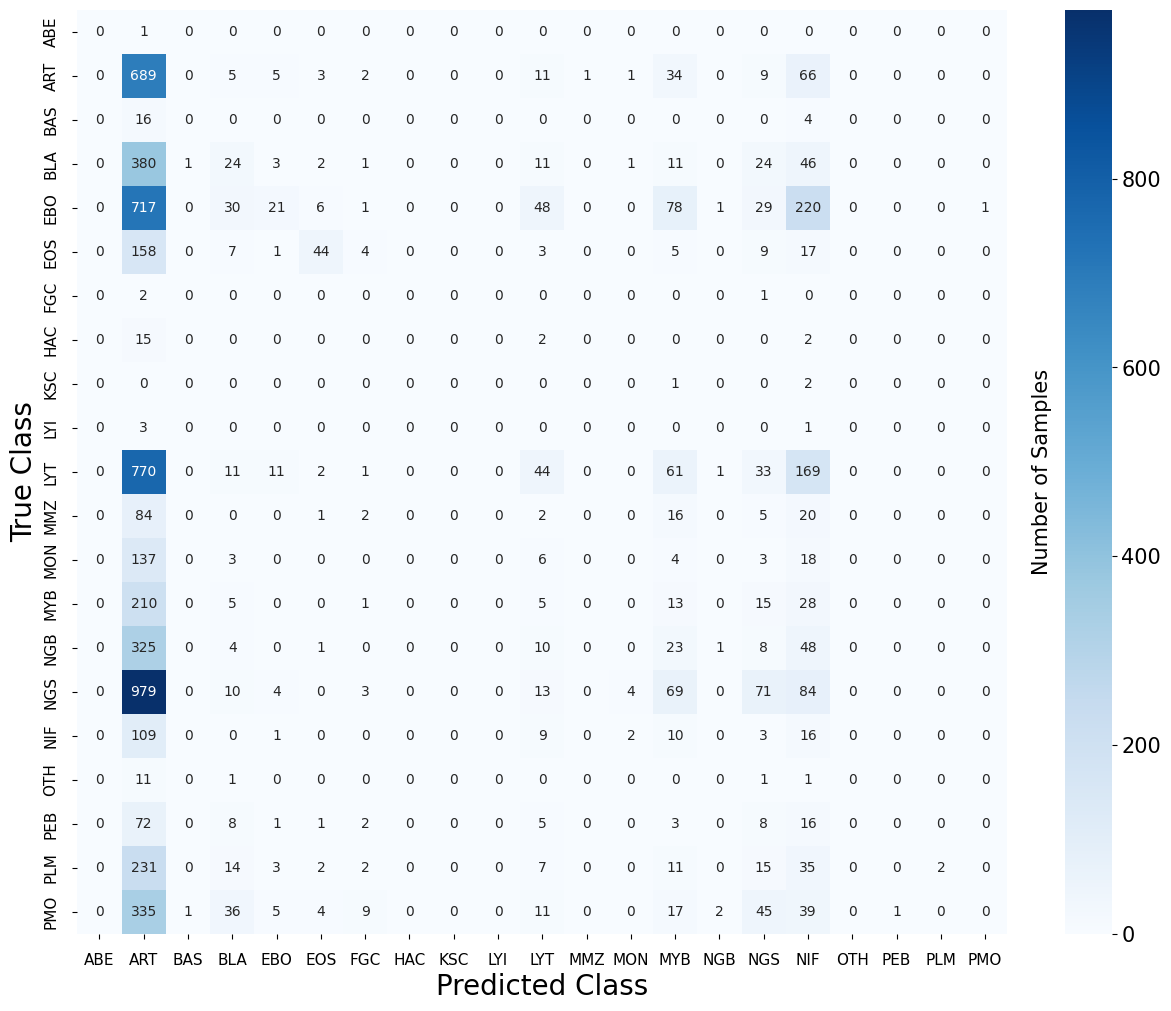

In [21]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

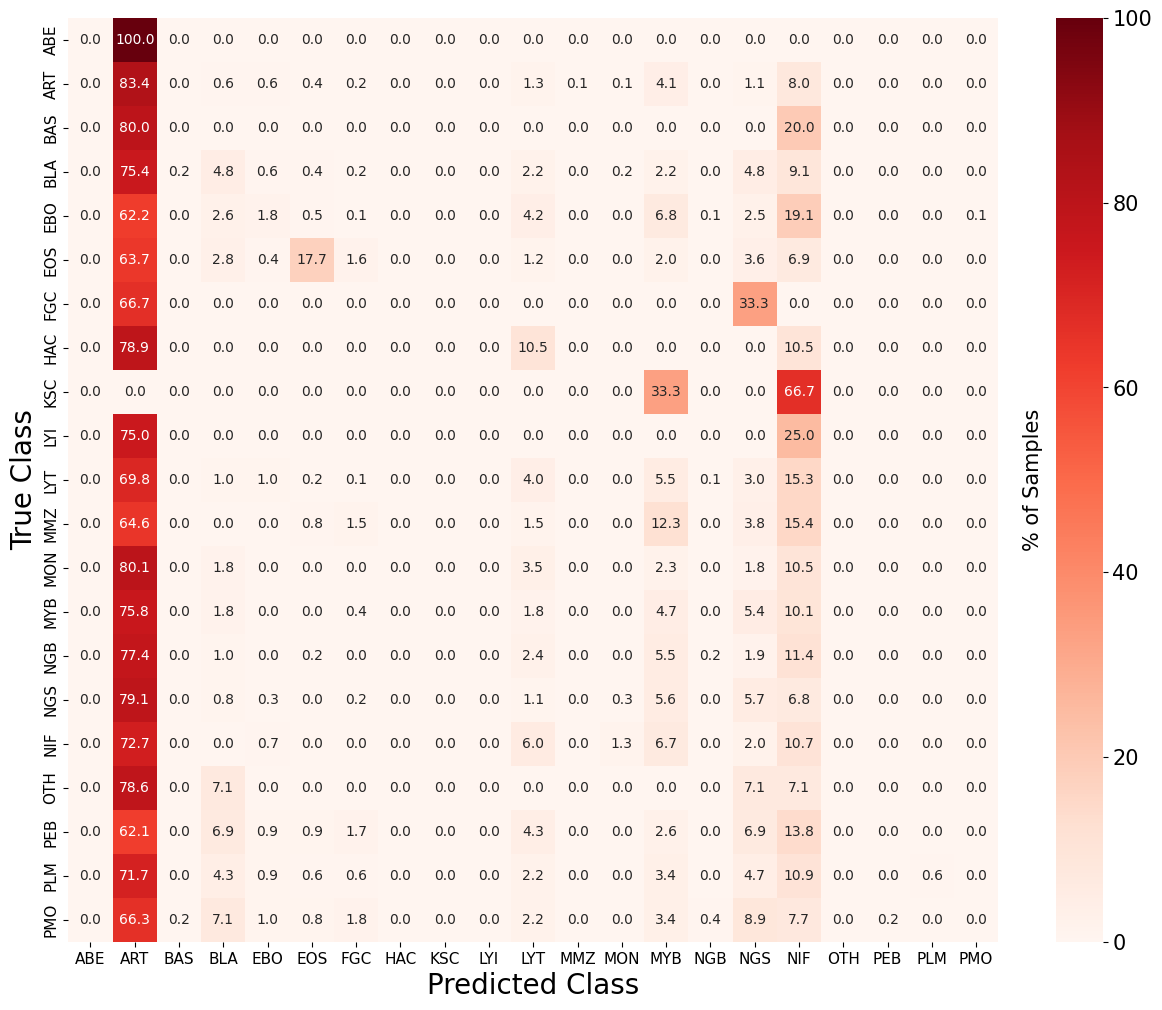

In [22]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 25 superpixel explanation 

In [23]:
reset_metrics()
y_true, y_pred = predict(data25)

2024-03-19 17:34:39.485956: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:34:39.486444: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7225]
	 [[{{node Placeholder/_0}}]]


In [24]:
acc_25 = acc
class_report, data25_pre = create_classification_report(y_true, y_pred)
pre_dict25 = generate_precision_dict(class_report)

Accuracy:0.18519030511379242
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.16      0.83      0.26       826
         BAS       0.00      0.00      0.00        20
         BLA       0.18      0.12      0.14       504
         EBO       0.52      0.08      0.14      1152
         EOS       0.41      0.39      0.40       248
         FGC       0.00      0.00      0.00         3
         HAC       0.00      0.00      0.00        19
         KSC       0.00      0.00      0.00         3
         LYI       0.00      0.00      0.00         4
         LYT       0.30      0.08      0.13      1103
         MMZ       0.00      0.00      0.00       130
         MON       0.18      0.01      0.02       171
         MYB       0.07      0.05      0.06       277
         NGB       0.03      0.00      0.00       420
         NGS       0.35      0.21      0.26      1237
         NIF       0.03     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

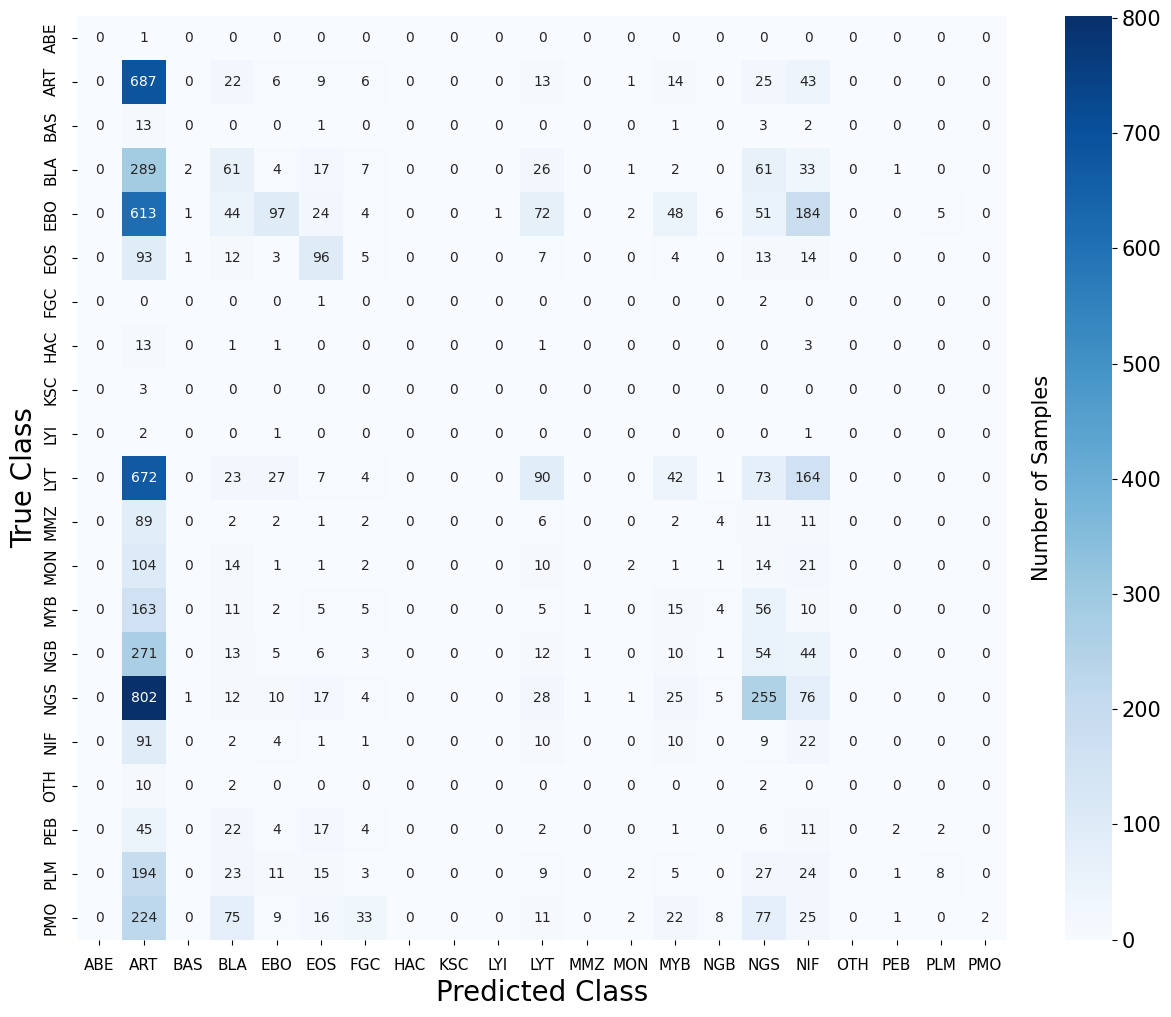

In [25]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

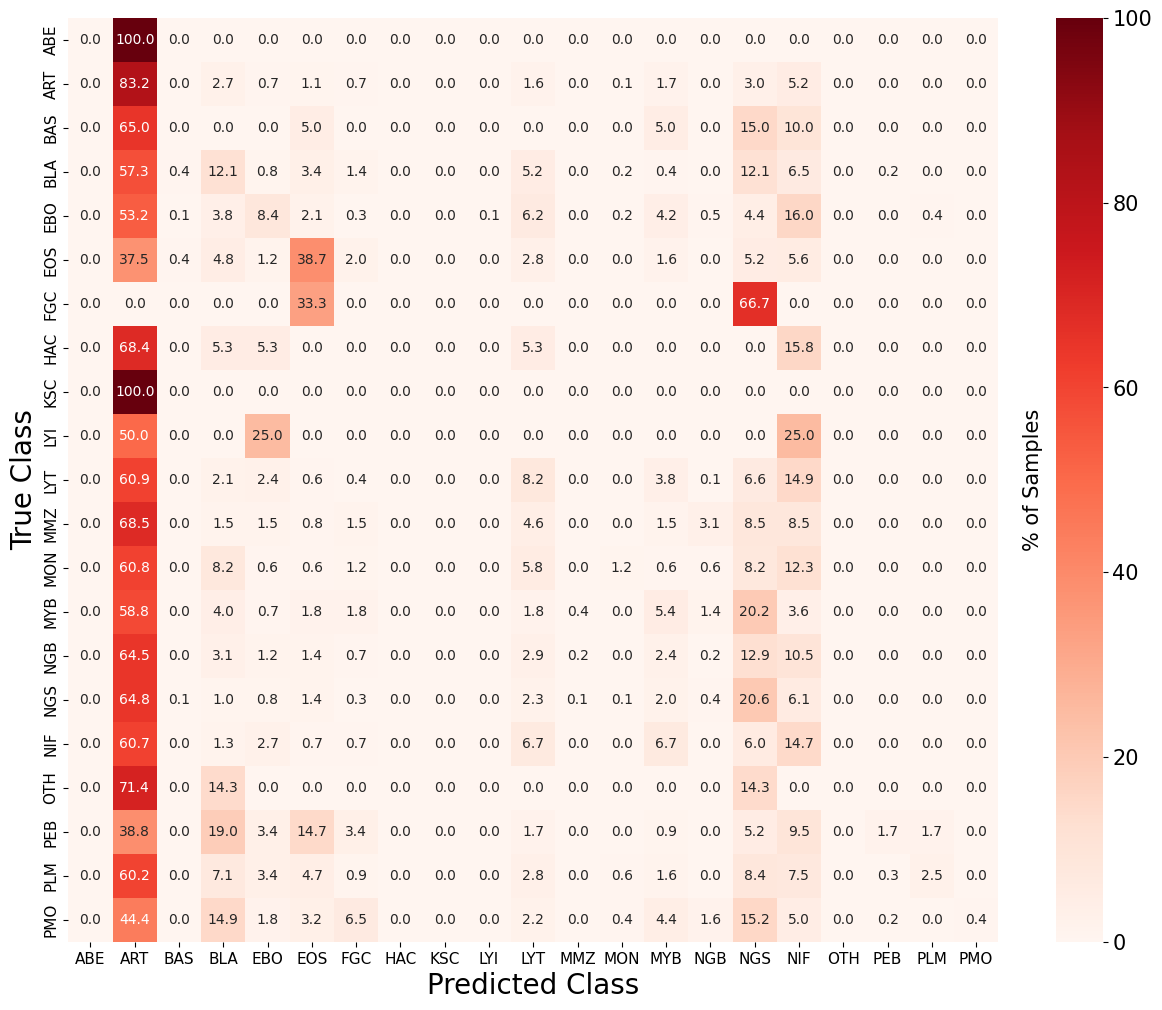

In [26]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 30 superpixel explanation 

In [27]:
reset_metrics()
y_true, y_pred = predict(data30)

2024-03-19 17:34:57.760153: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7224]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:34:57.760670: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7224]
	 [[{{node Placeholder/_4}}]]


In [28]:
acc_30 = acc
class_report, data30_pre = create_classification_report(y_true, y_pred)
pre_dict30 = generate_precision_dict(class_report)

Accuracy:0.2479235827922821
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.18      0.79      0.29       826
         BAS       0.10      0.05      0.07        20
         BLA       0.23      0.22      0.22       504
         EBO       0.58      0.17      0.27      1152
         EOS       0.39      0.49      0.43       248
         FGC       0.00      0.00      0.00         3
         HAC       0.00      0.00      0.00        19
         KSC       0.00      0.00      0.00         3
         LYI       0.00      0.00      0.00         4
         LYT       0.37      0.16      0.23      1102
         MMZ       0.00      0.00      0.00       130
         MON       0.18      0.02      0.03       171
         MYB       0.12      0.08      0.09       277
         NGB       0.14      0.02      0.04       420
         NGS       0.41      0.35      0.38      1237
         NIF       0.03      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

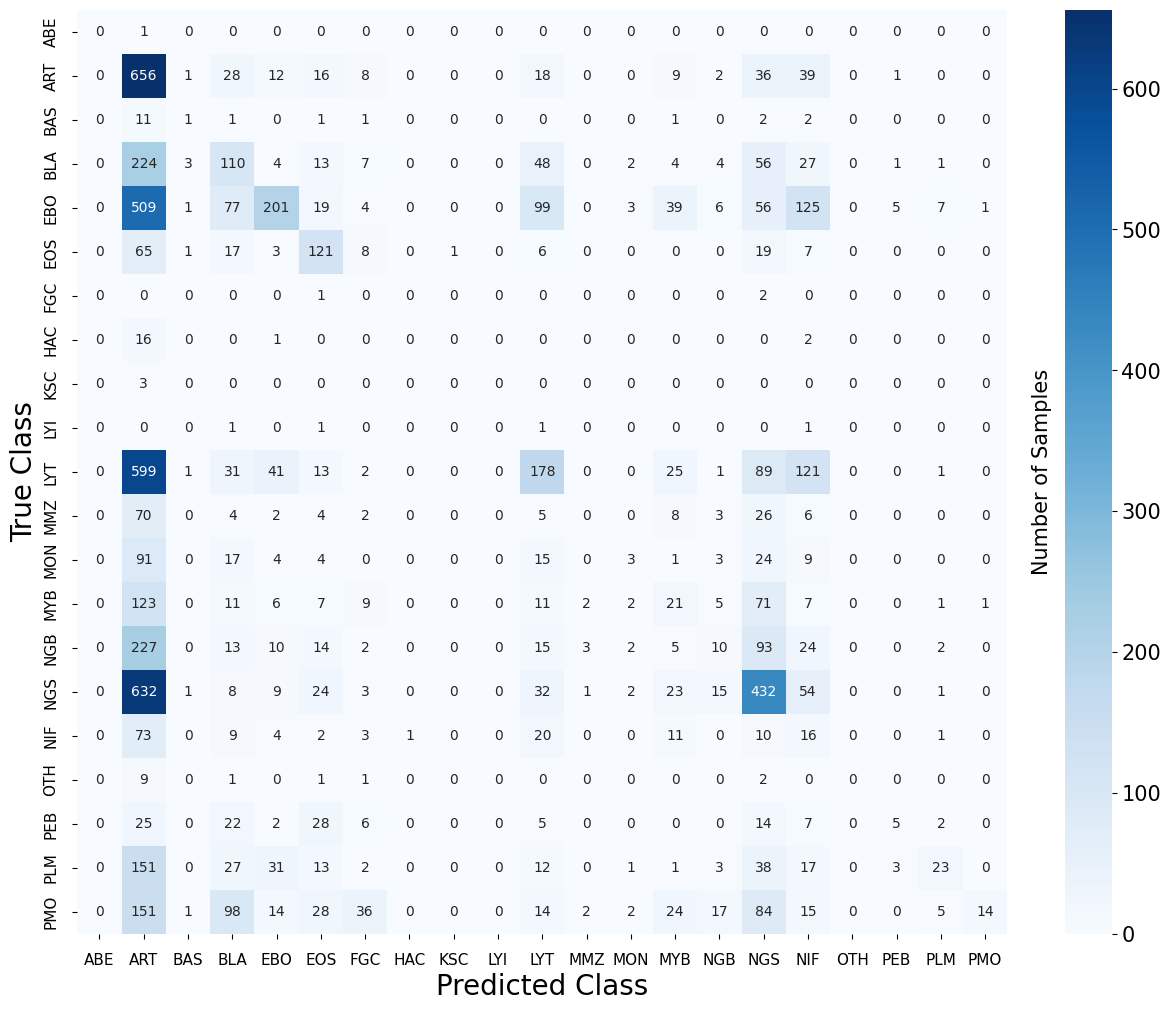

In [29]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

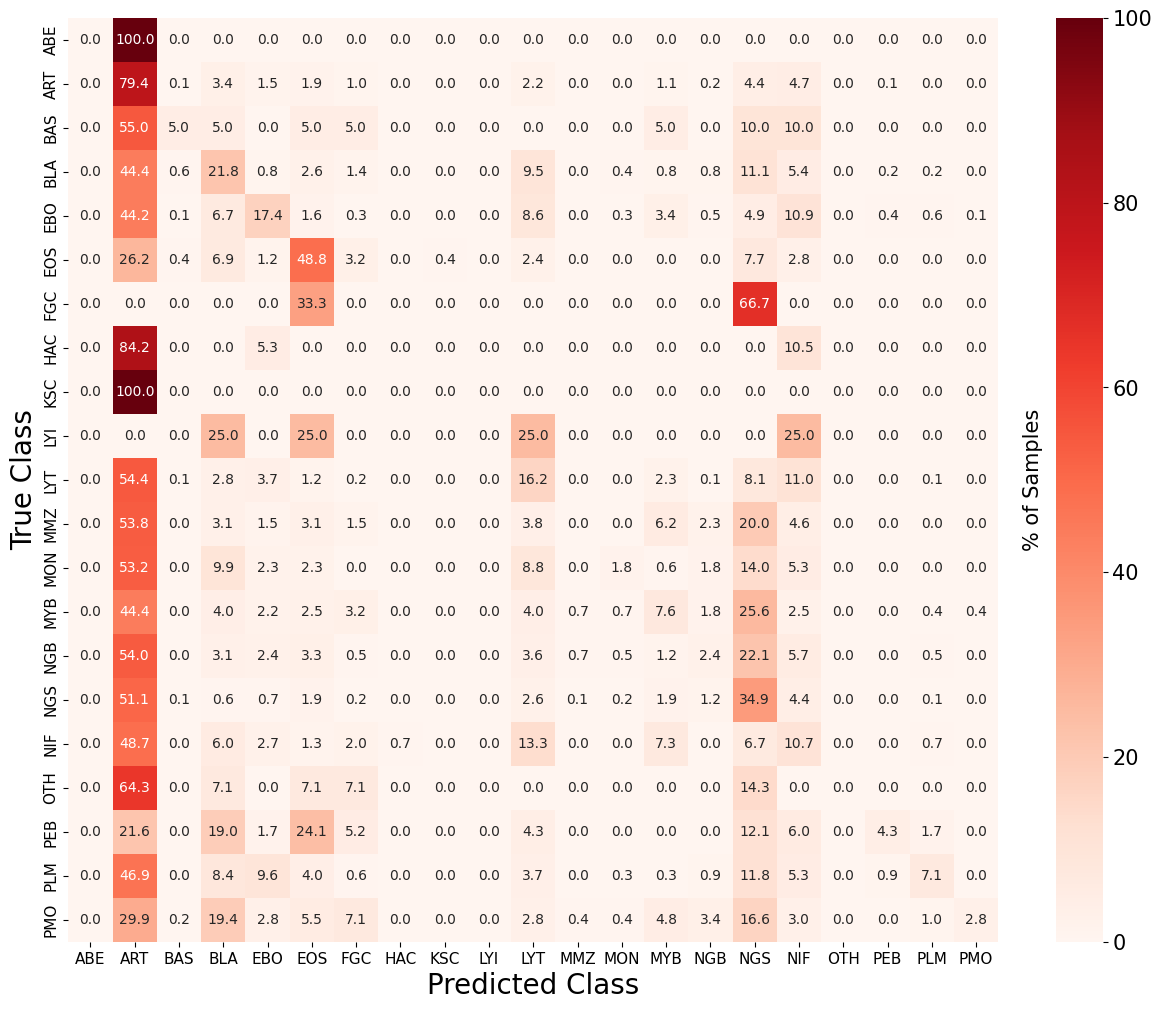

In [30]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 35 superpixel explanation 

In [31]:
reset_metrics()
y_true, y_pred = predict(data35)

2024-03-19 17:35:16.259262: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7181]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:35:16.259670: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7181]
	 [[{{node Placeholder/_4}}]]


In [32]:
acc_35 = acc
class_report, data35_pre = create_classification_report(y_true, y_pred)
pre_dict35 = generate_precision_dict(class_report)

Accuracy:0.35371118783950806
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.23      0.79      0.36       821
         BAS       0.10      0.05      0.07        20
         BLA       0.29      0.32      0.30       502
         EBO       0.66      0.33      0.44      1143
         EOS       0.52      0.64      0.57       247
         FGC       0.00      0.00      0.00         3
         HAC       0.00      0.00      0.00        18
         KSC       0.00      0.00      0.00         3
         LYI       0.00      0.00      0.00         4
         LYT       0.50      0.31      0.38      1088
         MMZ       0.10      0.02      0.04       127
         MON       0.28      0.08      0.12       171
         MYB       0.17      0.11      0.13       276
         NGB       0.23      0.07      0.11       420
         NGS       0.49      0.53      0.51      1234
         NIF       0.06     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

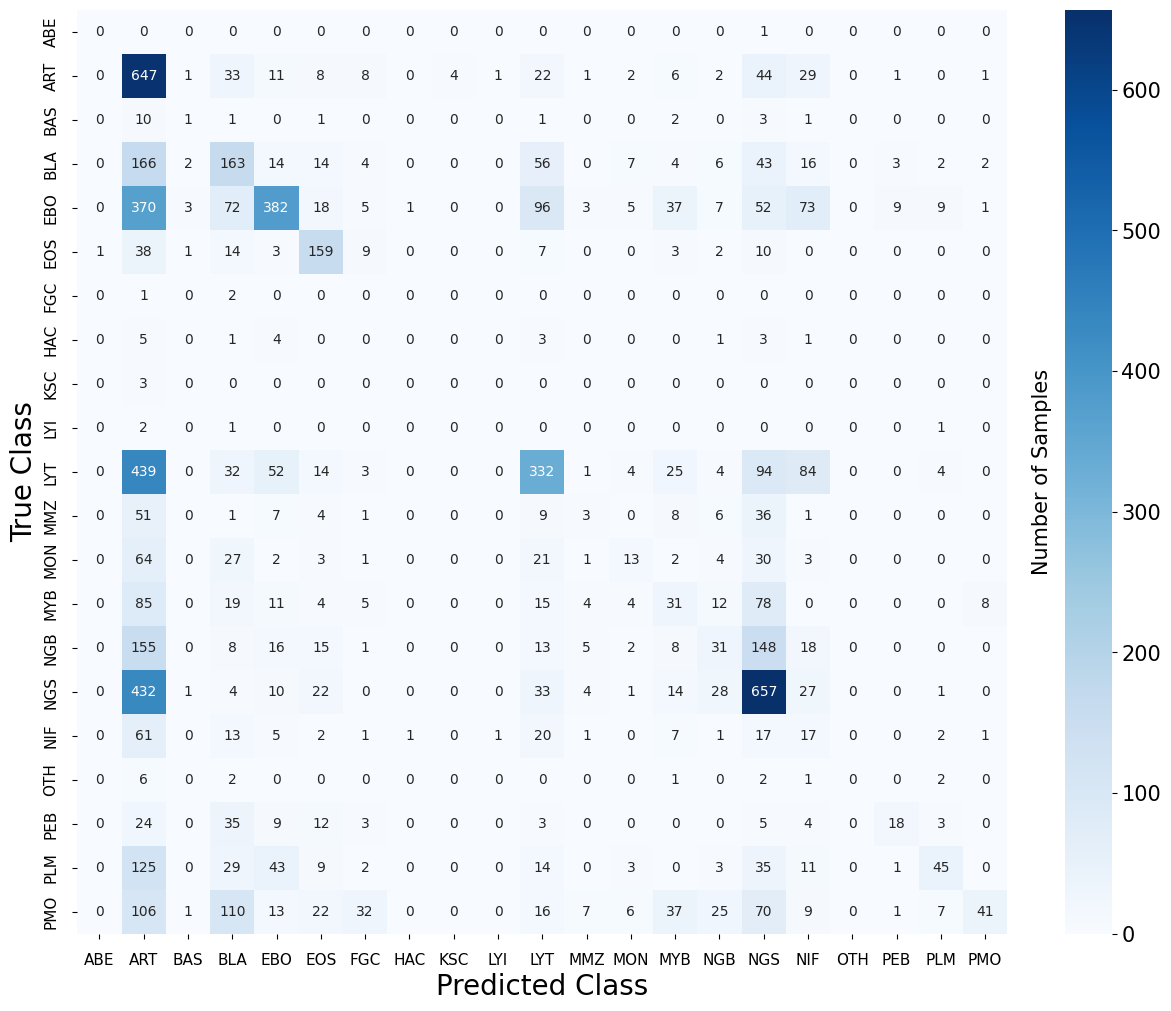

In [33]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

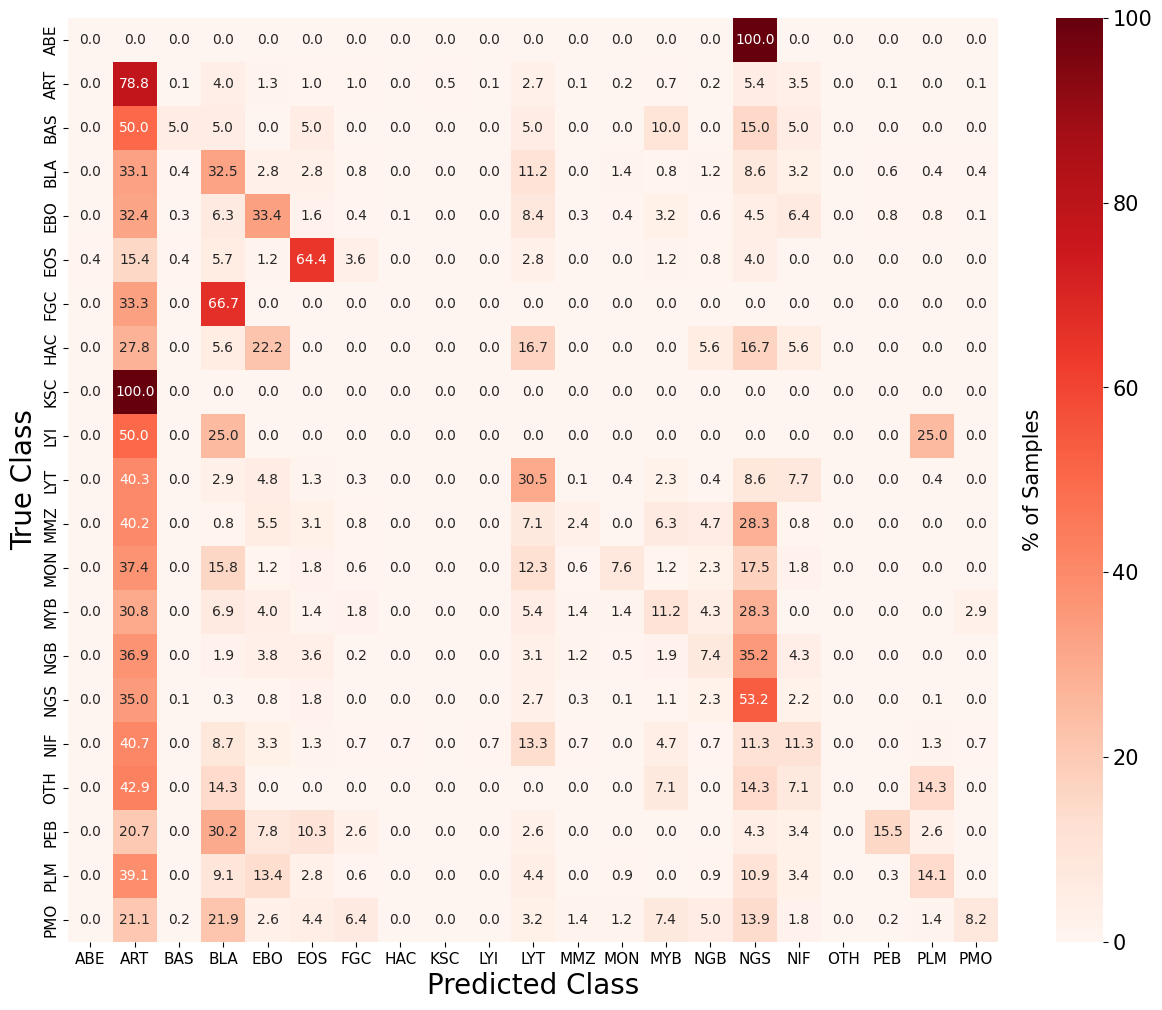

In [34]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 40 superpixel explanation 

In [35]:
reset_metrics()
y_true, y_pred = predict(data40)

2024-03-19 17:35:35.586264: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6592]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:35:35.586706: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6592]
	 [[{{node Placeholder/_0}}]]


In [36]:
acc_40 = acc
class_report, data40_pre = create_classification_report(y_true, y_pred)
pre_dict40 = generate_precision_dict(class_report)

Accuracy:0.48558858036994934
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.32      0.79      0.45       741
         BAS       0.19      0.15      0.17        20
         BLA       0.40      0.48      0.44       467
         EBO       0.73      0.52      0.61      1020
         EOS       0.62      0.73      0.67       230
         FGC       0.02      0.33      0.05         3
         HAC       0.20      0.06      0.09        17
         KSC       0.00      0.00      0.00         2
         LYI       0.00      0.00      0.00         3
         LYT       0.63      0.46      0.53       961
         MMZ       0.16      0.06      0.08       121
         MON       0.42      0.25      0.32       162
         MYB       0.28      0.21      0.24       262
         NGB       0.34      0.19      0.24       397
         NGS       0.60      0.69      0.64      1156
         NIF       0.15     

### Confusion matrices

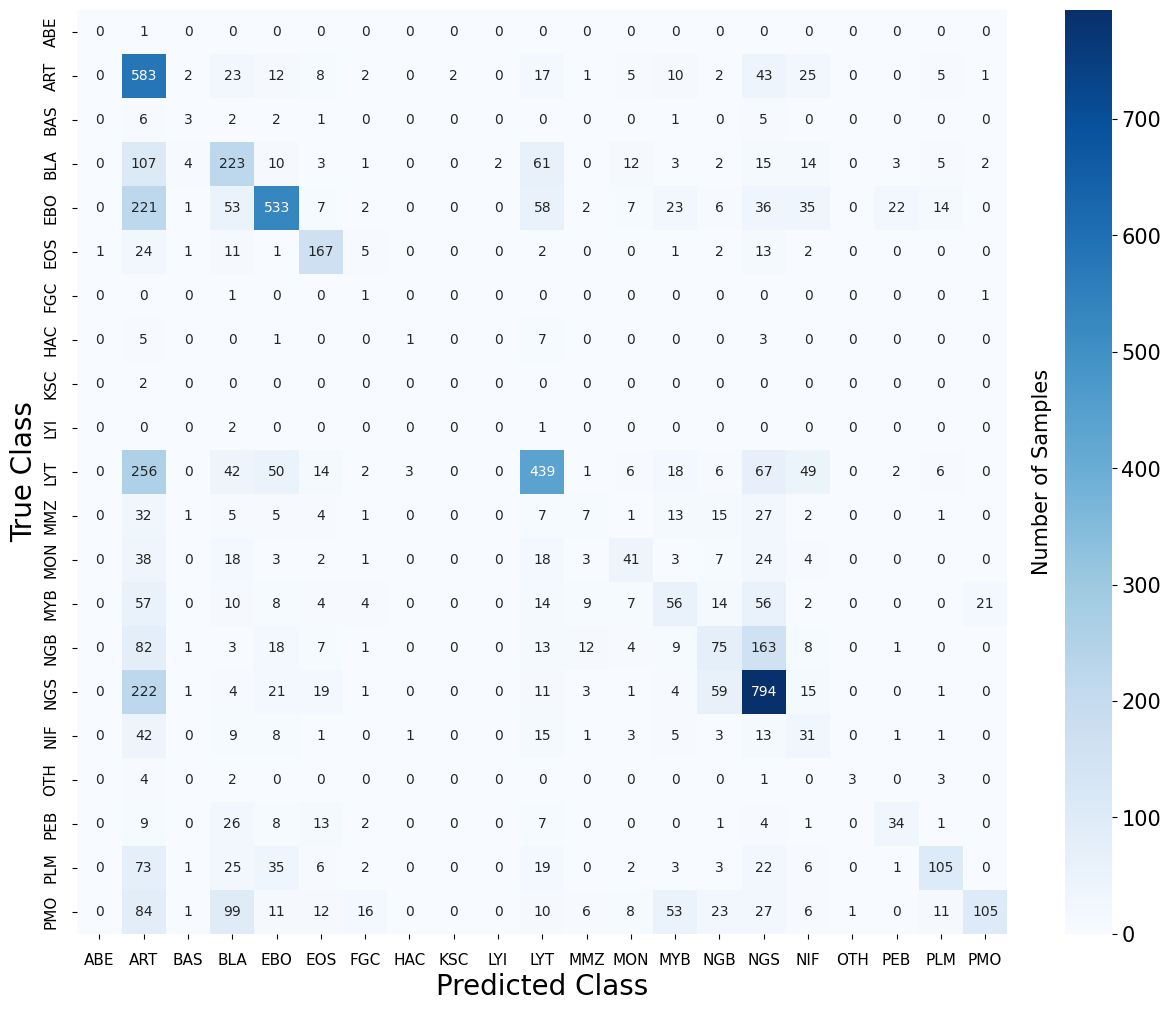

In [37]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

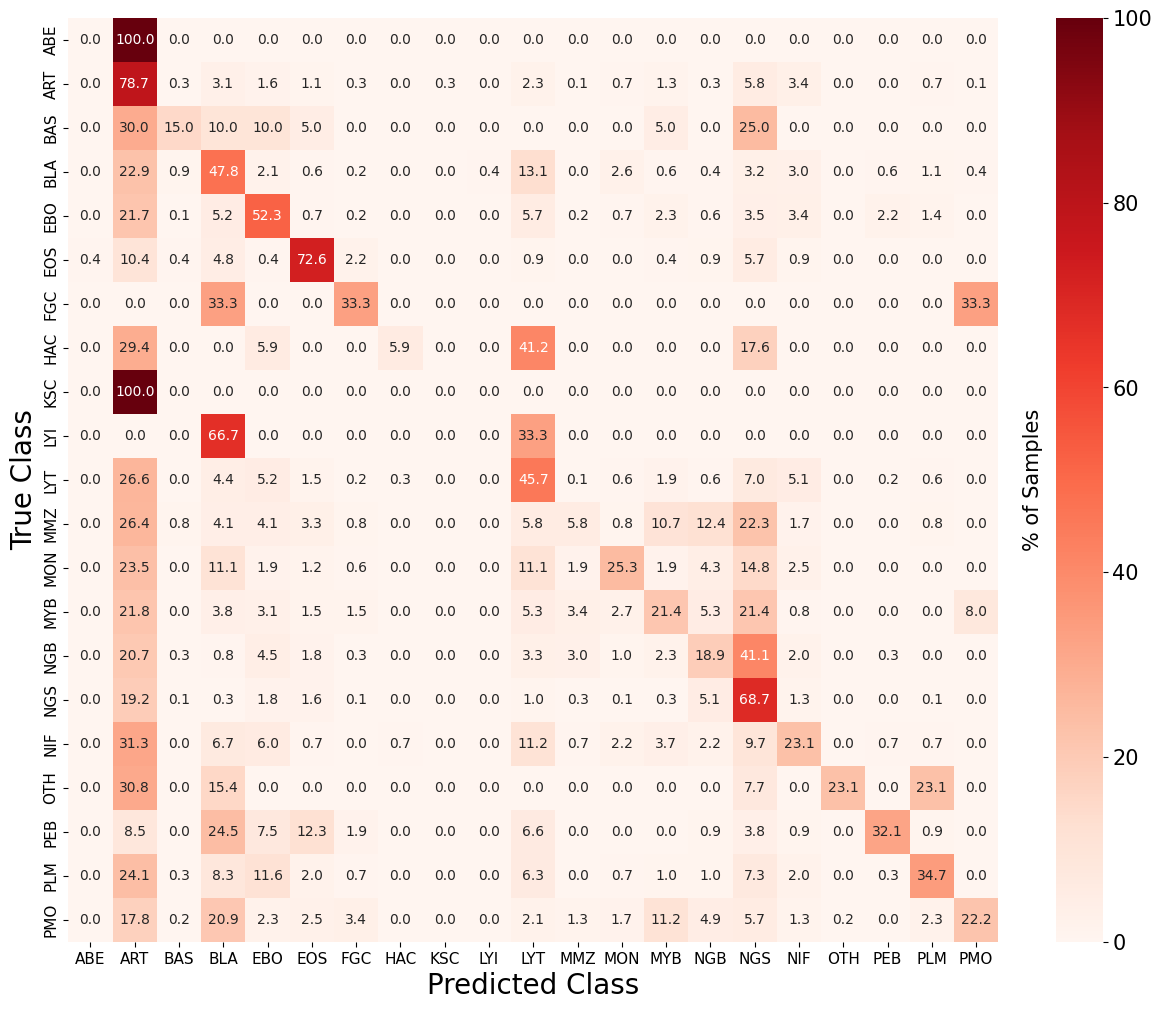

In [38]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for 45 superpixel explanation

In [39]:
reset_metrics()
y_true, y_pred = predict(data45)

2024-03-19 17:35:52.517784: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4162]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:35:52.520824: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4162]
	 [[{{node Placeholder/_0}}]]


In [40]:
acc_45 = acc
class_report, data45_pre = create_classification_report(y_true, y_pred)
pre_dict45 = generate_precision_dict(class_report)

Accuracy:0.5927438735961914
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.40      0.78      0.53       433
         BAS       0.28      0.38      0.32        13
         BLA       0.53      0.61      0.57       289
         EBO       0.75      0.65      0.70       583
         EOS       0.81      0.83      0.82       149
         FGC       0.00      0.00      0.00         1
         HAC       0.31      0.44      0.36         9
         KSC       0.00      0.00      0.00         1
         LYI       0.00      0.00      0.00         3
         LYT       0.67      0.57      0.62       536
         MMZ       0.25      0.15      0.19        86
         MON       0.36      0.32      0.34       108
         MYB       0.46      0.39      0.42       172
         NGB       0.46      0.31      0.37       275
         NGS       0.71      0.76      0.74       797
         NIF       0.17      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Confusion matrices

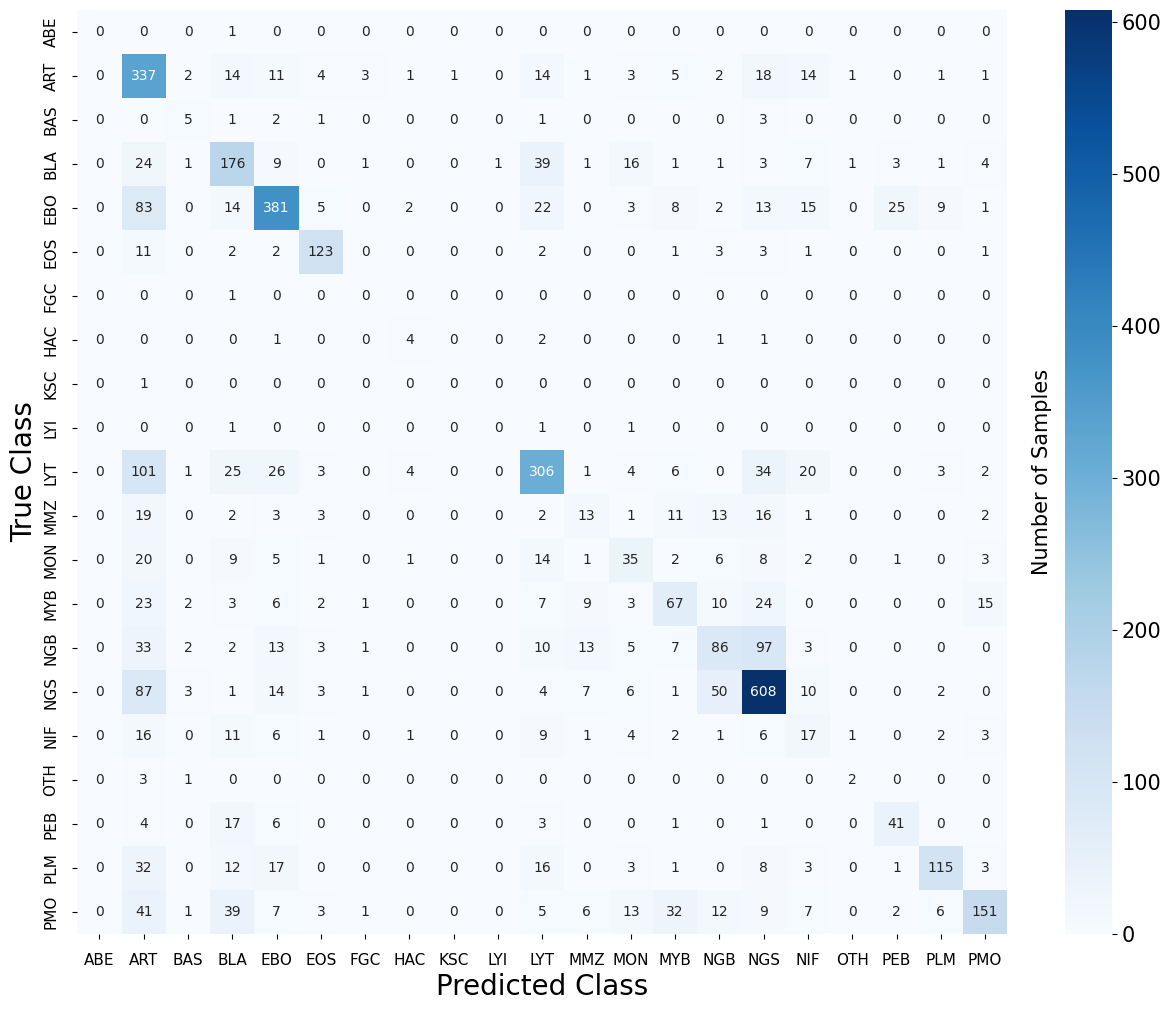

In [41]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

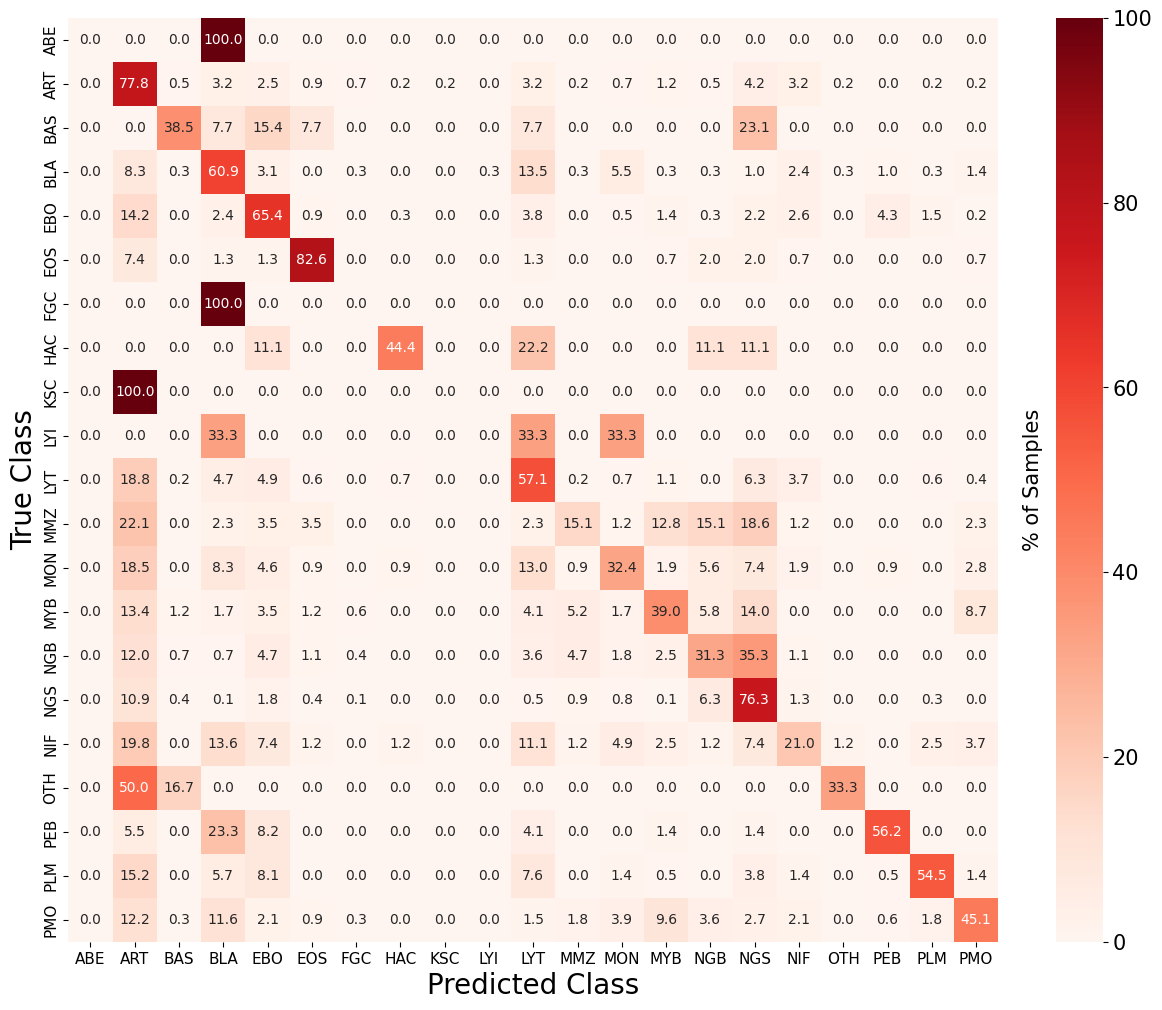

In [42]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Metrics for full image

In [43]:
reset_metrics()
y_true, y_pred = predict(data_all)

2024-03-19 17:36:04.381598: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]
2024-03-19 17:36:04.382149: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7225]
	 [[{{node Placeholder/_4}}]]


In [44]:
acc_all = acc
class_report, data_all_pre = create_classification_report(y_true, y_pred)
pre_dict_all = generate_precision_dict(class_report)

Accuracy:0.7717646956443787
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.81      0.82      0.81       826
         BAS       0.39      0.45      0.42        20
         BLA       0.69      0.76      0.72       504
         EBO       0.91      0.89      0.90      1152
         EOS       0.90      0.92      0.91       248
         FGC       0.33      0.33      0.33         3
         HAC       0.31      0.58      0.41        19
         KSC       0.17      0.33      0.22         3
         LYI       0.33      0.50      0.40         4
         LYT       0.87      0.81      0.84      1103
         MMZ       0.27      0.38      0.31       130
         MON       0.54      0.64      0.59       171
         MYB       0.60      0.58      0.59       277
         NGB       0.53      0.66      0.59       420
         NGS       0.91      0.76      0.83      1237
         NIF       0.44      

### Confusion matrices

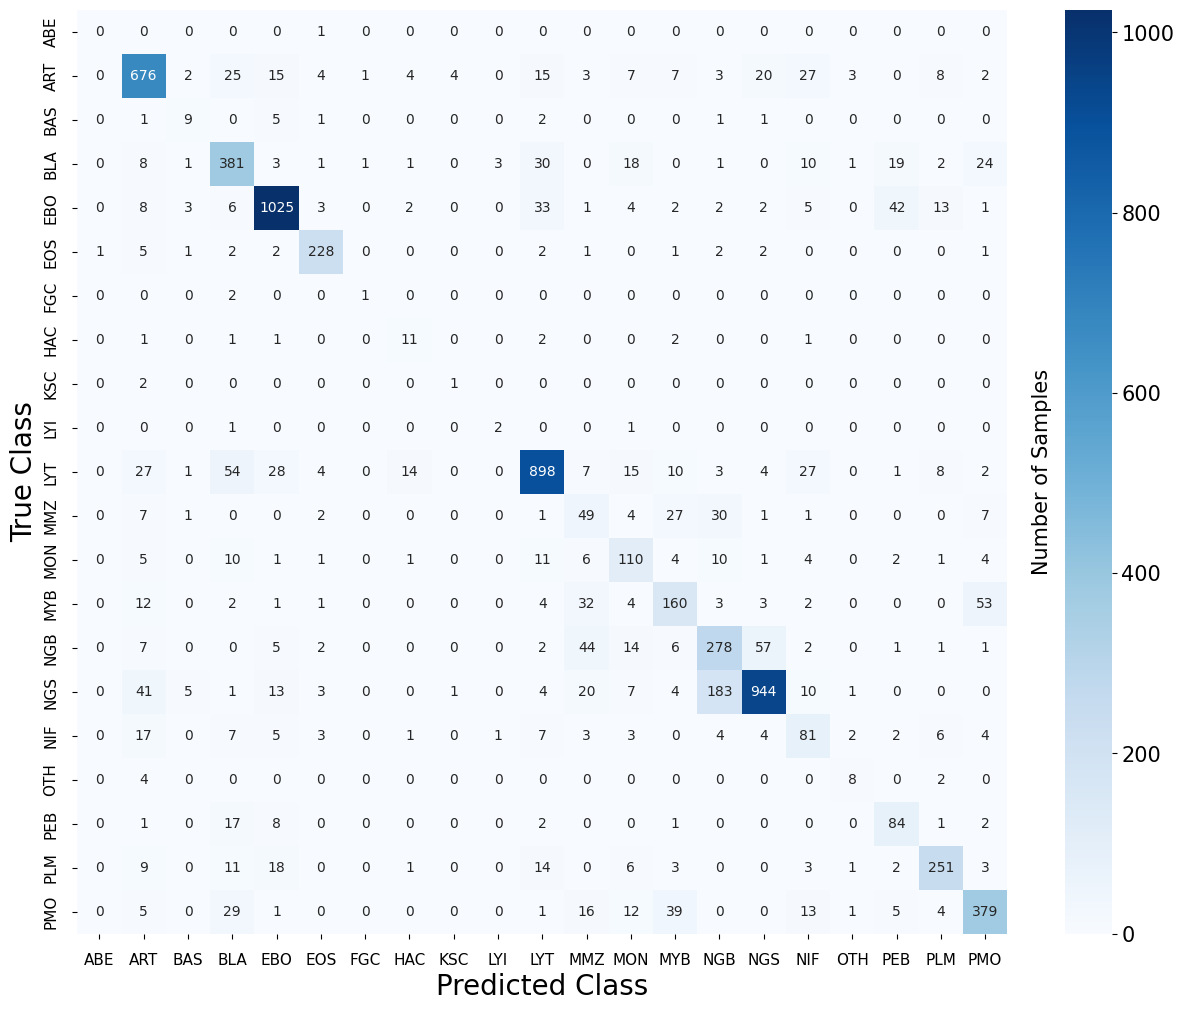

In [45]:
conf_matrix = generate_conf_matrix(y_true, y_pred)

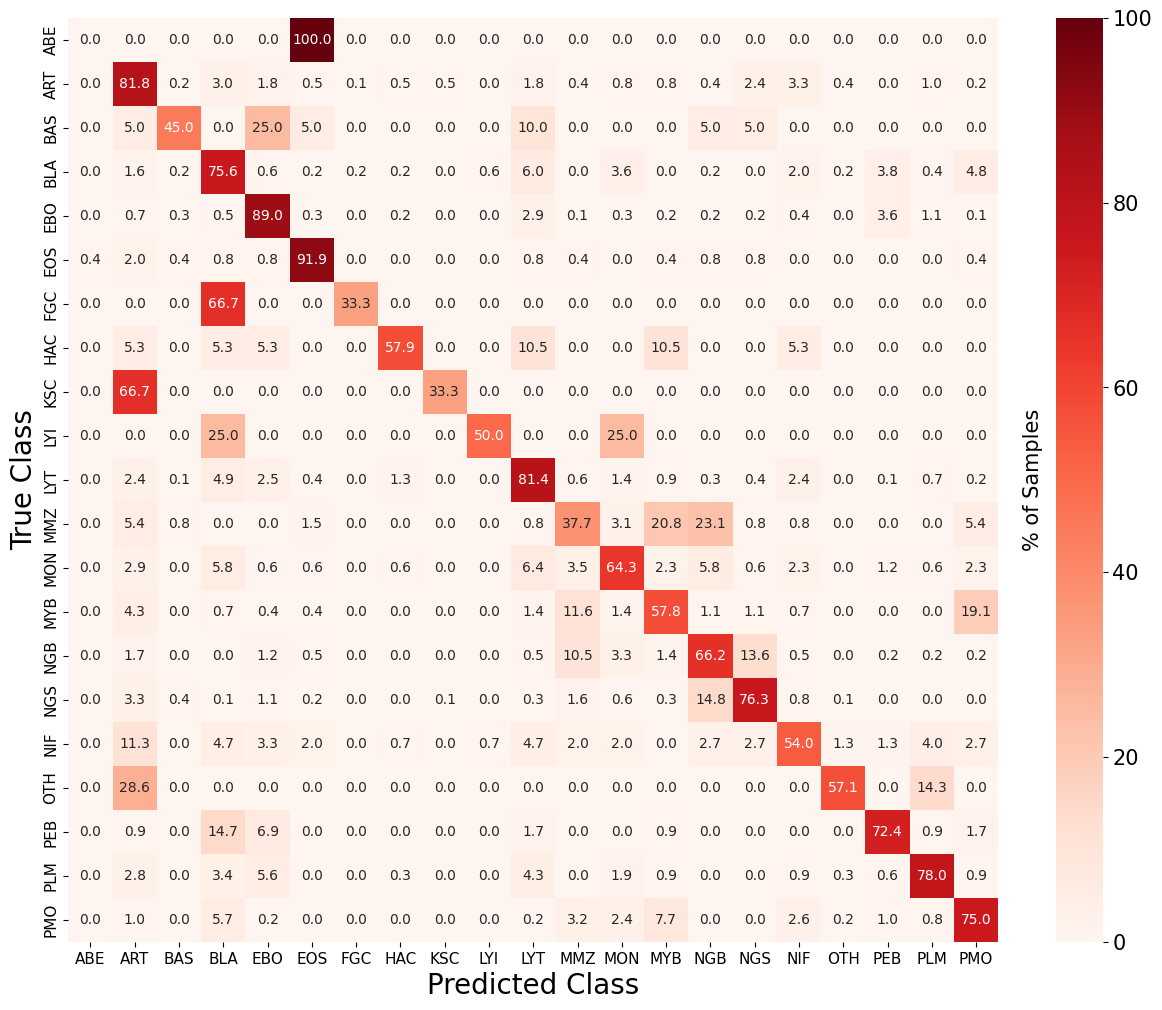

In [46]:
normalised_conf_matrix = generate_normalised_conf_matrix(conf_matrix)

# Create Accuracy & Precision Graphs

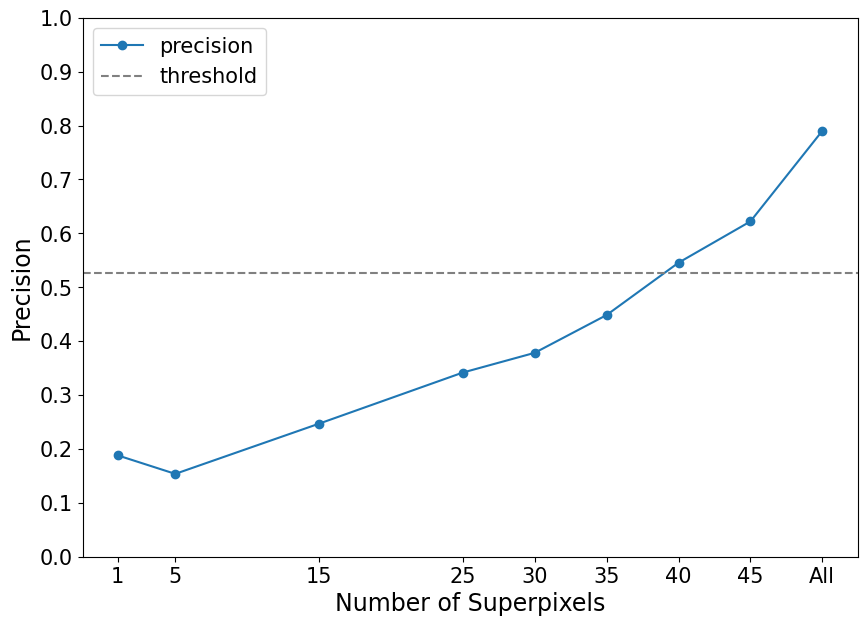

In [47]:
# Create a graph of precision over the number of superpixels
plt.figure(figsize=(10, 7))
plt.plot([1, 5, 15, 25, 30, 35, 40, 45, 50], 
         [data1_pre, data5_pre, data15_pre, data25_pre, data30_pre, data35_pre, data40_pre, data45_pre, data_all_pre], 
         marker='o',
         label="precision")
plt.xticks([1, 5, 15, 25, 30, 35, 40, 45, 50], ['1', '5', '15', '25', '30', '35', '40', '45', 'All'])
plt.ylim(0, 1.0)
plt.yticks([i/10 for i in range(11)])  # Set y-axis ticks with 0.1 increments
plt.xlabel("Number of Superpixels", fontsize=17)
plt.ylabel("Precision", fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Threshold as described in Shah and Sheppard's paper
threshold = 2/3 * data_all_pre
plt.axhline(y=threshold, color='gray', linestyle='--', label="threshold")

plt.legend(loc='upper left', fontsize=15)

plt.show()

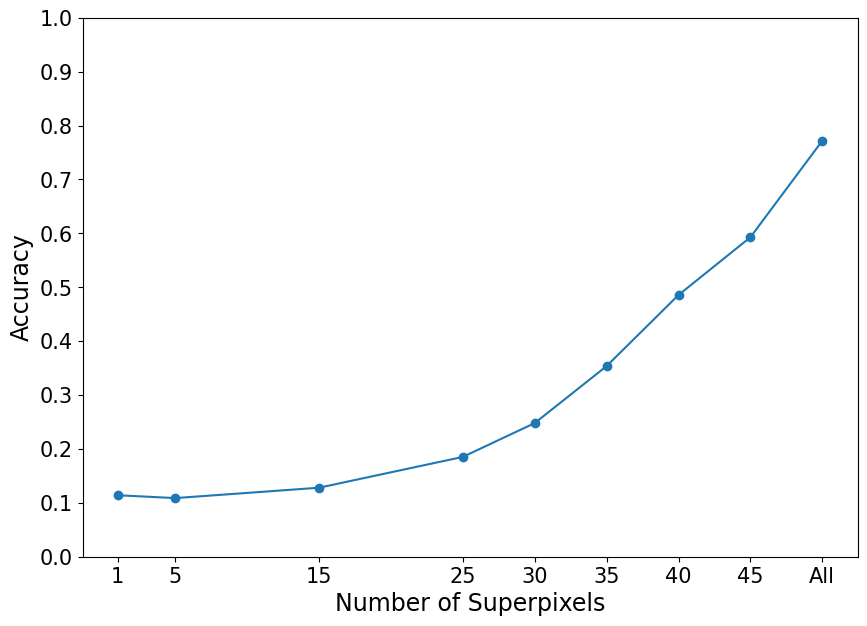

In [76]:
plt.figure(figsize=(10, 7))
plt.plot([1, 5, 15, 25, 30, 35, 40, 45, 50], 
         [acc_1.result().numpy(), acc_5.result().numpy(), acc_15.result().numpy(), acc_25.result().numpy(), acc_30.result().numpy(), acc_35.result().numpy(), acc_40.result().numpy(), acc_45.result().numpy(), acc_all.result().numpy()], 
         marker='o')
plt.xticks([1, 5, 15, 25, 30, 35, 40, 45, 50], ['1', '5', '15', '25', '30', '35', '40', '45', 'All'])
plt.ylim(0, 1.0)
plt.yticks([i/10 for i in range(11)])  # Set y-axis ticks with 0.1 increments
plt.xlabel("Number of Superpixels", fontsize=17)
plt.ylabel("Accuracy", fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [49]:
def create_class_precision_graph(class_name, pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all):
    plt.figure(figsize=(10, 7))
    plt.plot([1, 5, 15, 25, 30, 35, 40, 45, 50], 
             [pre_dict1[class_name], pre_dict5[class_name], pre_dict15[class_name], pre_dict25[class_name], pre_dict30[class_name], pre_dict35[class_name], pre_dict40[class_name], pre_dict45[class_name], pre_dict_all[class_name]], marker='o', label="precision")
    plt.xticks([1, 5, 15, 25, 30, 35, 40, 45, 50], ['1', '5', '15', '25', '30', '35', '40', '45', 'All'])
    plt.ylim(0, 1.0)
    plt.yticks([i/10 for i in range(11)])  # Set y-axis ticks with 0.1 increments
    #plt.title(f"Precision of {class_name} Over the Number of Superpixels", fontsize=20)
    plt.xlabel("Number of Superpixels", fontsize=17)
    plt.ylabel("Precision", fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    all_precision = pre_dict_all[class_name]
    # Threshold as described in Shah and Sheppard's paper
    threshold = 2/3 * all_precision
    plt.axhline(y=threshold, color='gray', linestyle='--', label="threshold")
    
    plt.legend(loc='upper left', fontsize=15)
    
    plt.show()

## Precision of ABE Over the Number of Superpixels

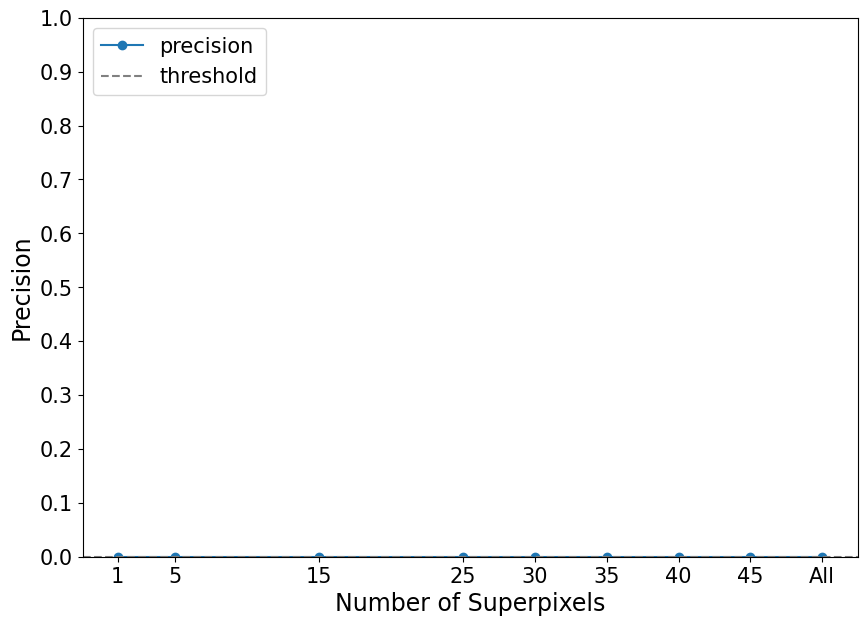

In [71]:
create_class_precision_graph("ABE", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of ART Over the Number of Superpixels

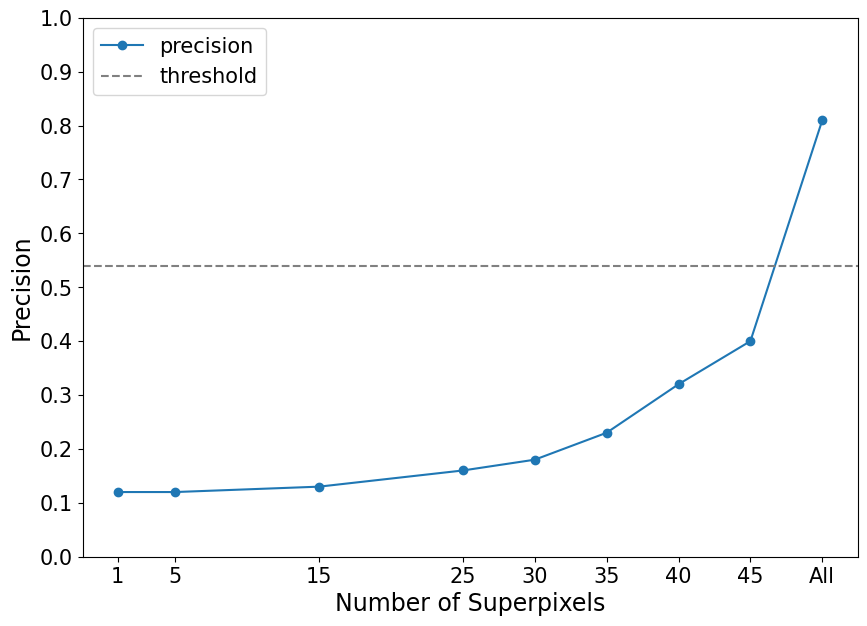

In [51]:
create_class_precision_graph("ART", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of BAS Over the Number of Superpixels

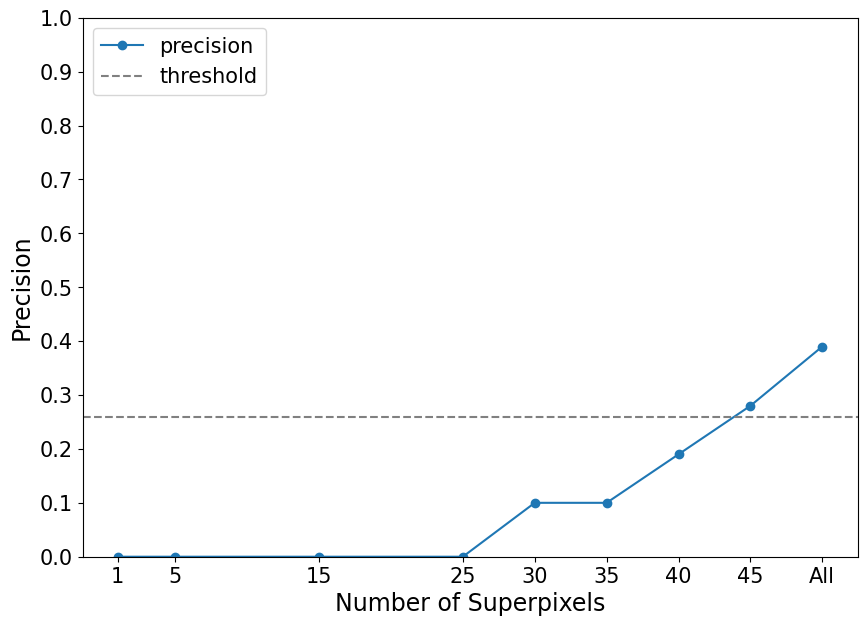

In [52]:
create_class_precision_graph("BAS", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of BLA Over the Number of Superpixels

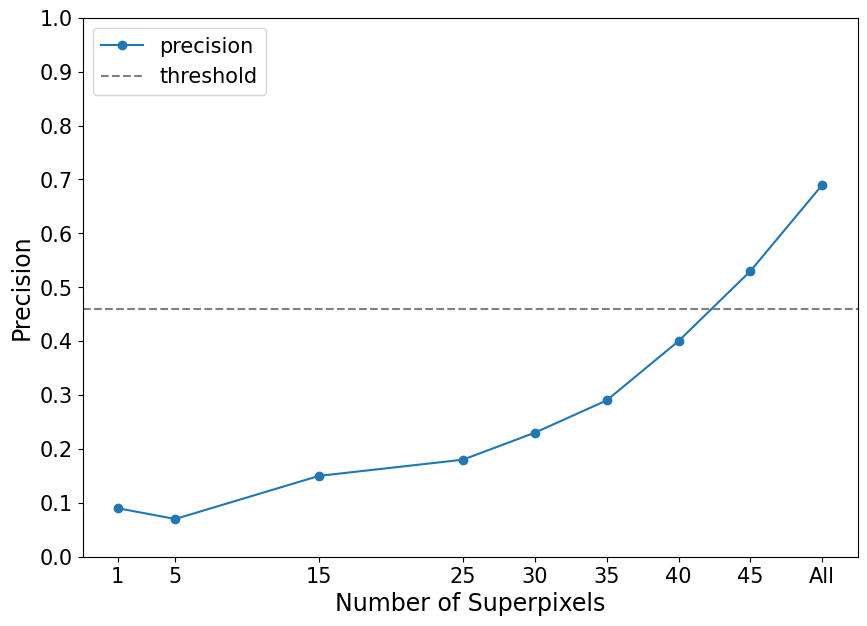

In [53]:
create_class_precision_graph("BLA", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of EBO Over the Number of Superpixels

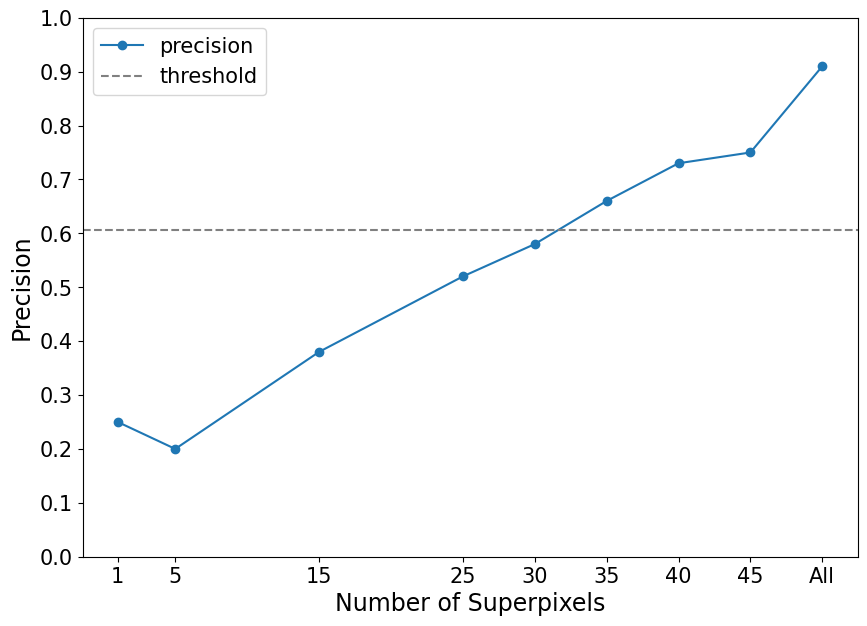

In [54]:
create_class_precision_graph("EBO", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of EOS Over the Number of Superpixels

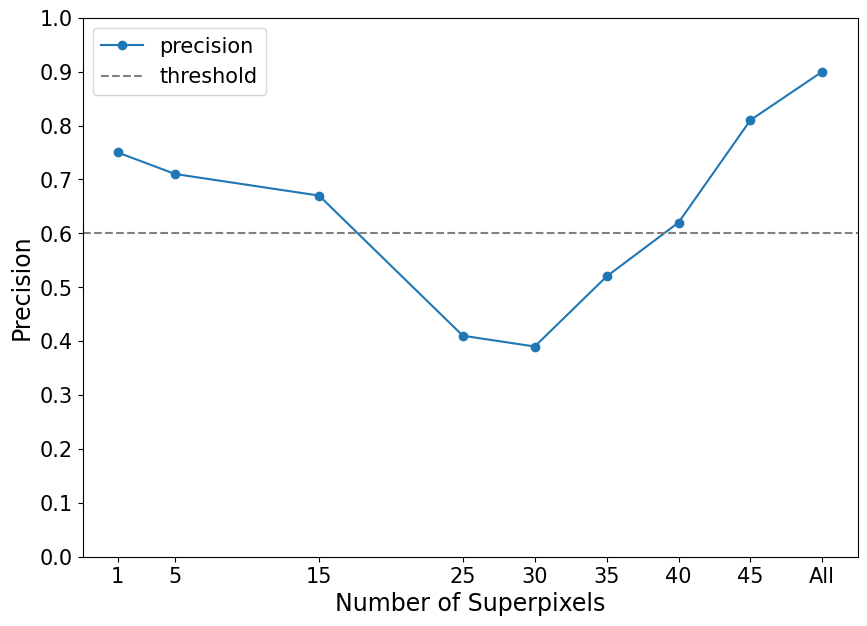

In [55]:
create_class_precision_graph("EOS", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of FGC Over the Number of Superpixels

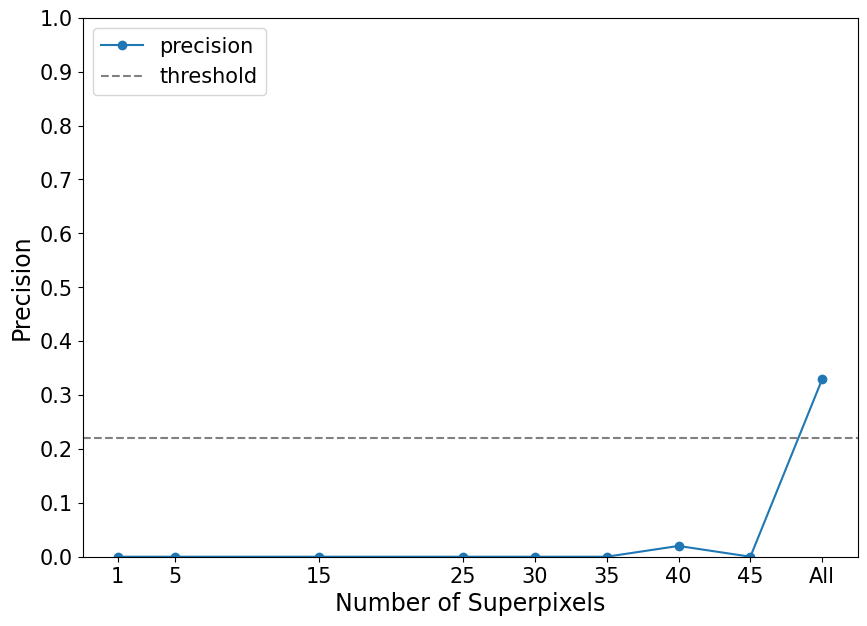

In [56]:
create_class_precision_graph("FGC", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of HAC Over the Number of Superpixels

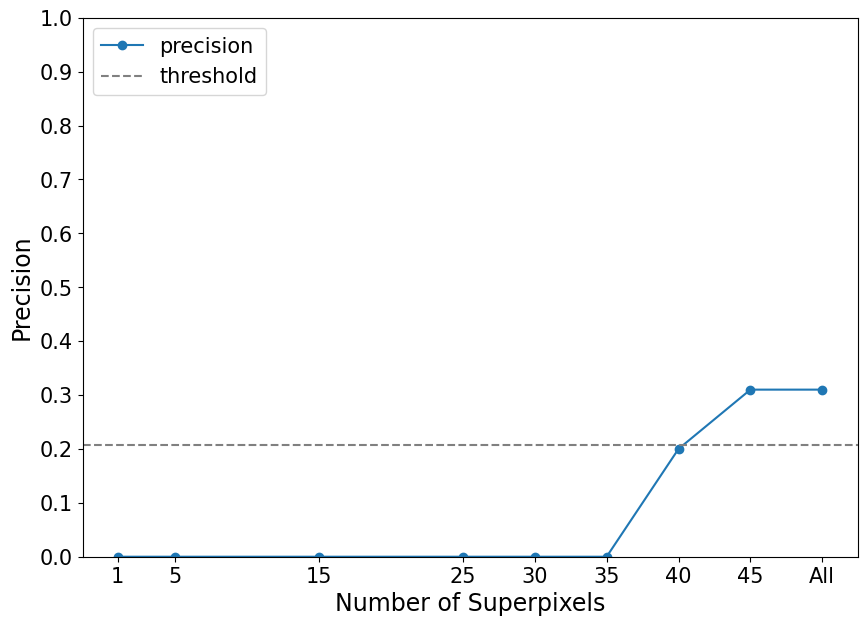

In [57]:
create_class_precision_graph("HAC", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of KSC Over the Number of Superpixels

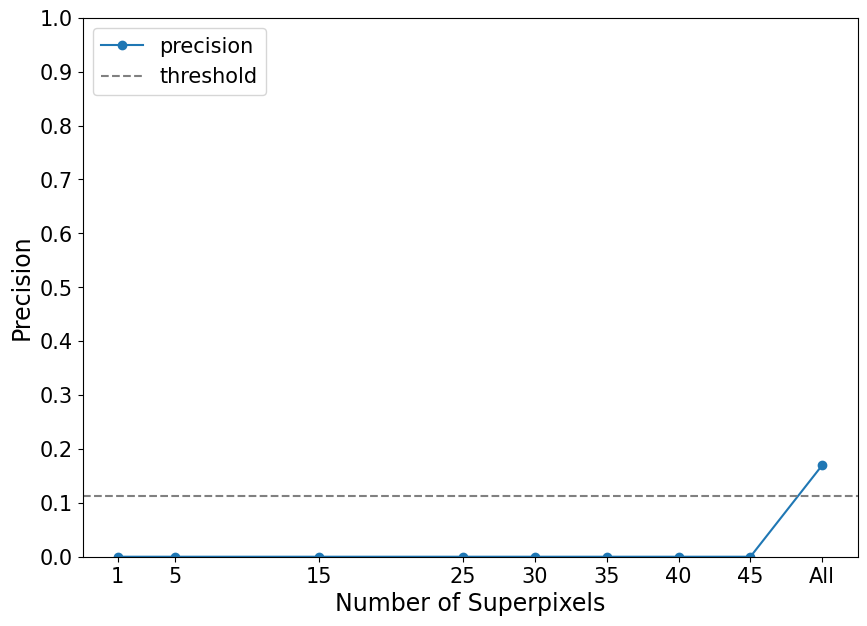

In [58]:
create_class_precision_graph("KSC", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of LYI Over the Number of Superpixels

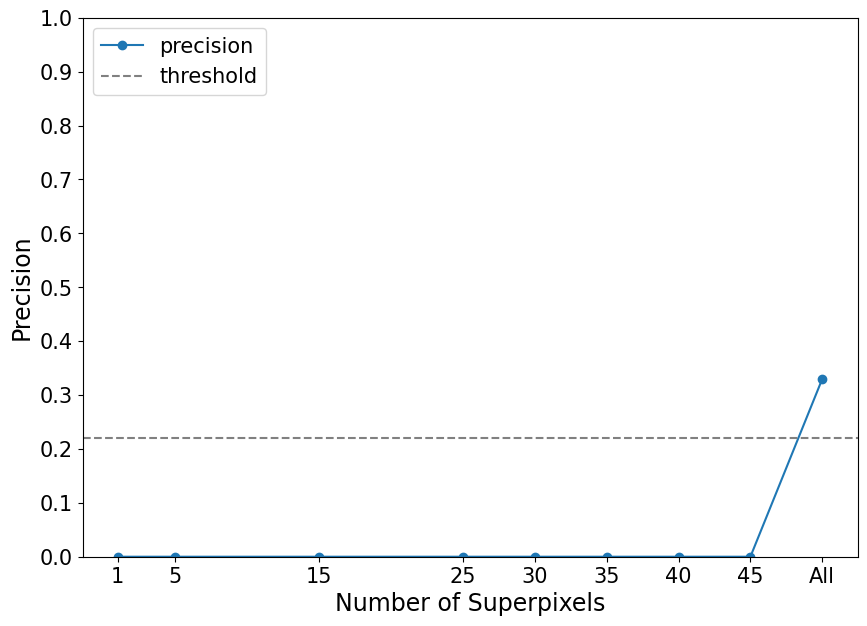

In [59]:
create_class_precision_graph("LYI", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of LYT Over the Number of Superpixels

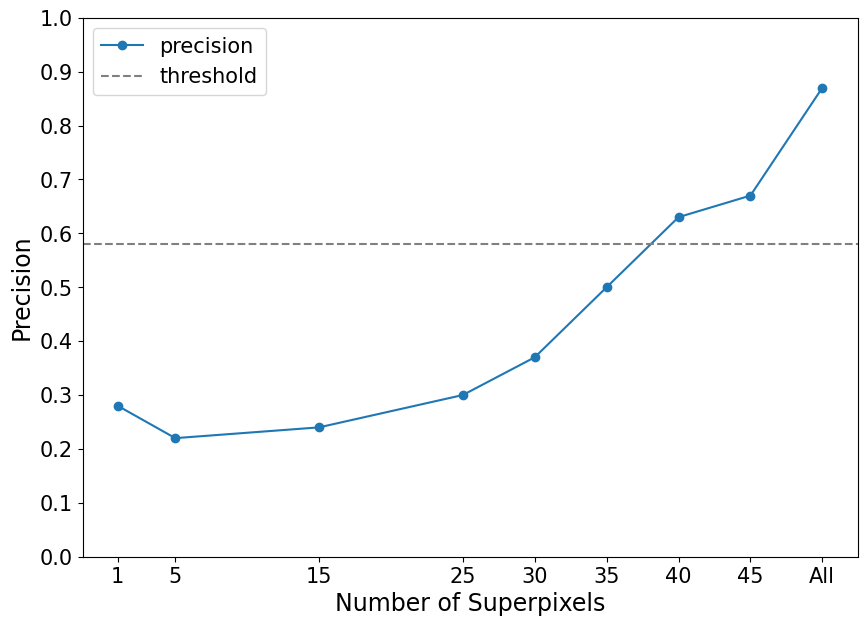

In [60]:
create_class_precision_graph("LYT", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of MMZ Over the Number of Superpixels

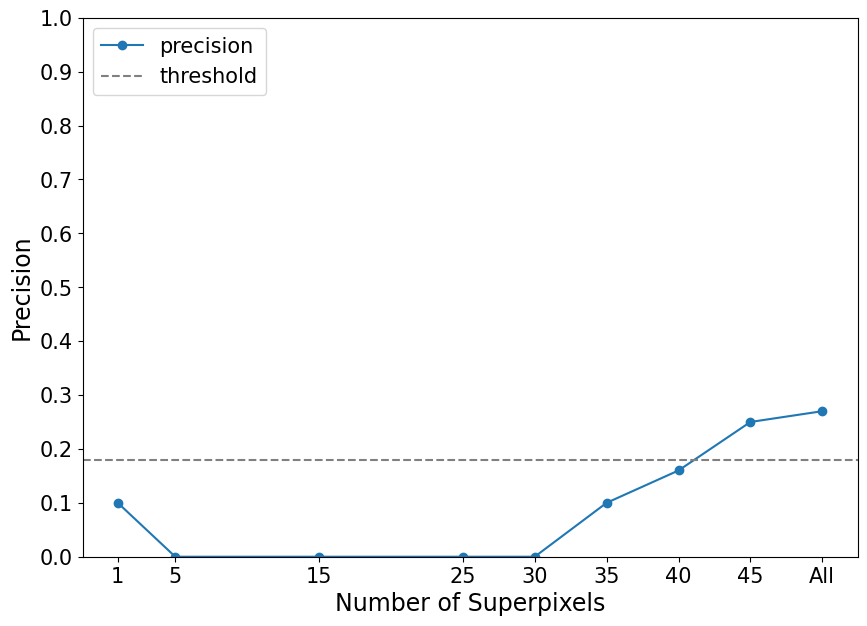

In [61]:
create_class_precision_graph("MMZ", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of MON Over the Number of Superpixels

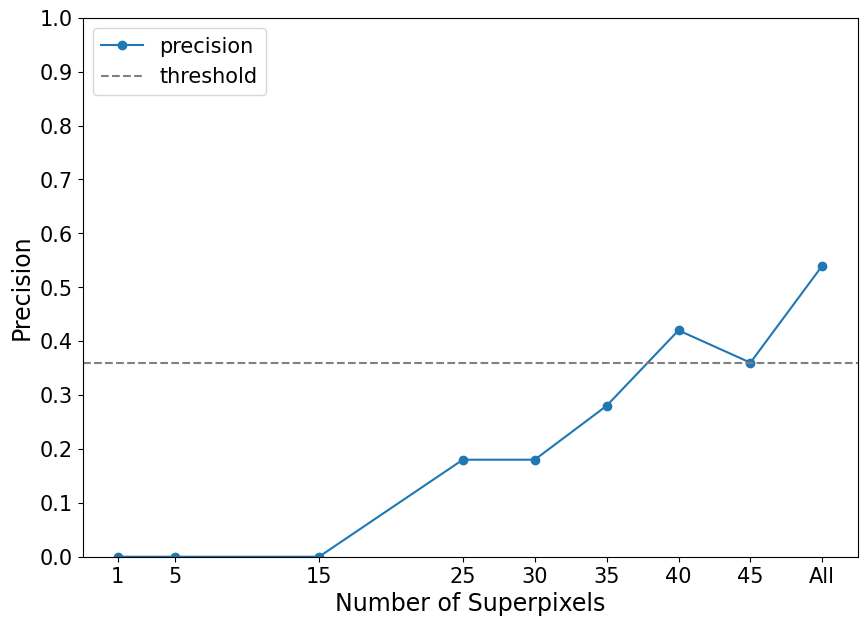

In [62]:
create_class_precision_graph("MON", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of MYB Over the Number of Superpixels

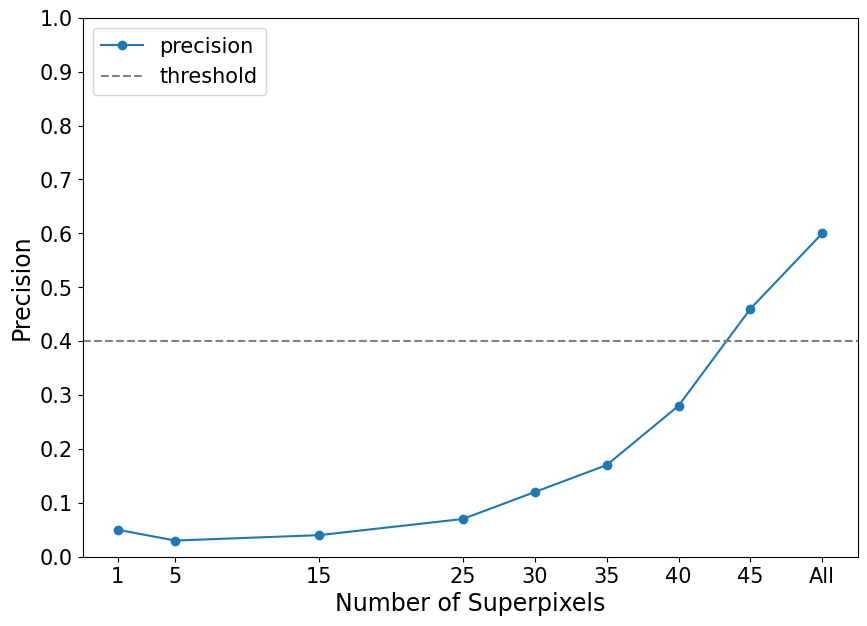

In [63]:
create_class_precision_graph("MYB", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of NGB Over the Number of Superpixels

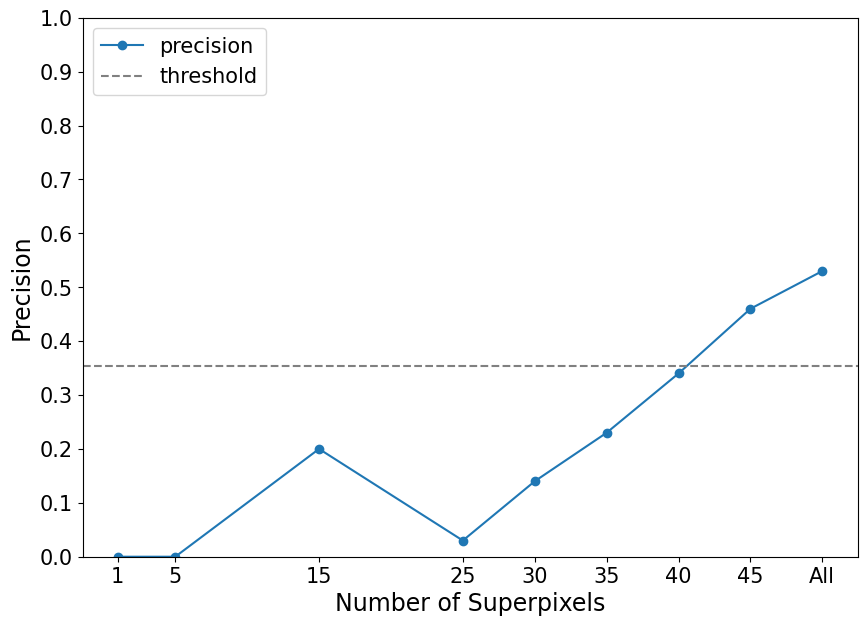

In [64]:
create_class_precision_graph("NGB", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of NGS Over the Number of Superpixels

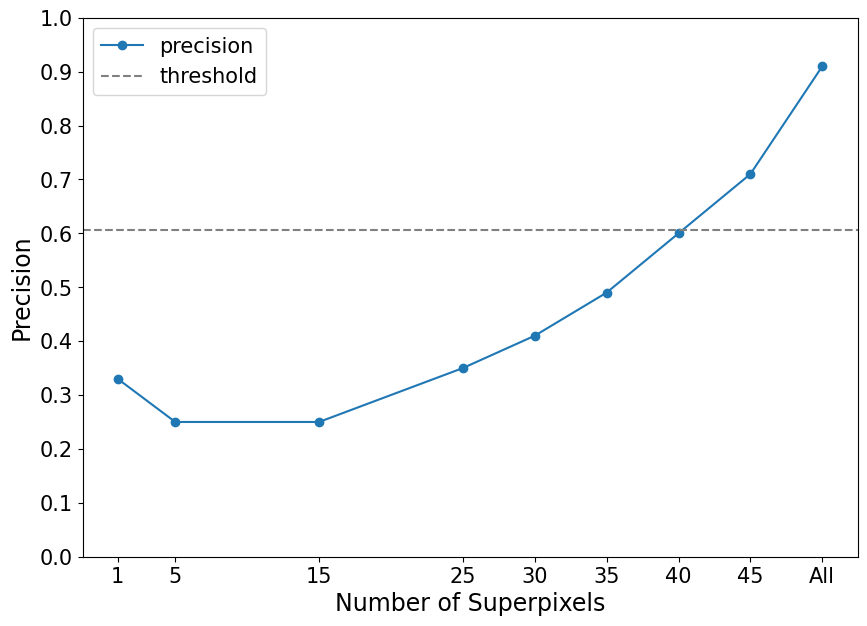

In [65]:
create_class_precision_graph("NGS", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of NIF Over the Number of Superpixels

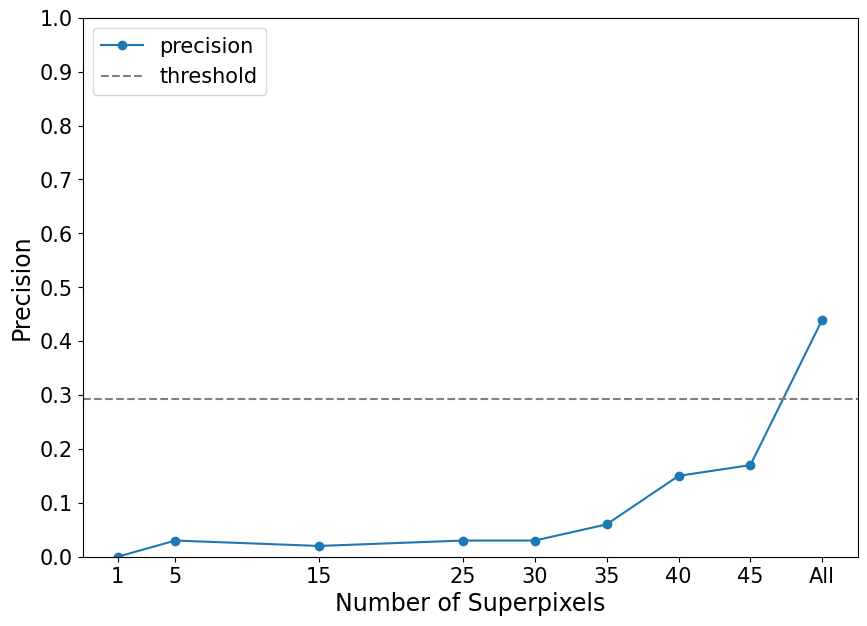

In [66]:
create_class_precision_graph("NIF", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of OTH Over the Number of Superpixels

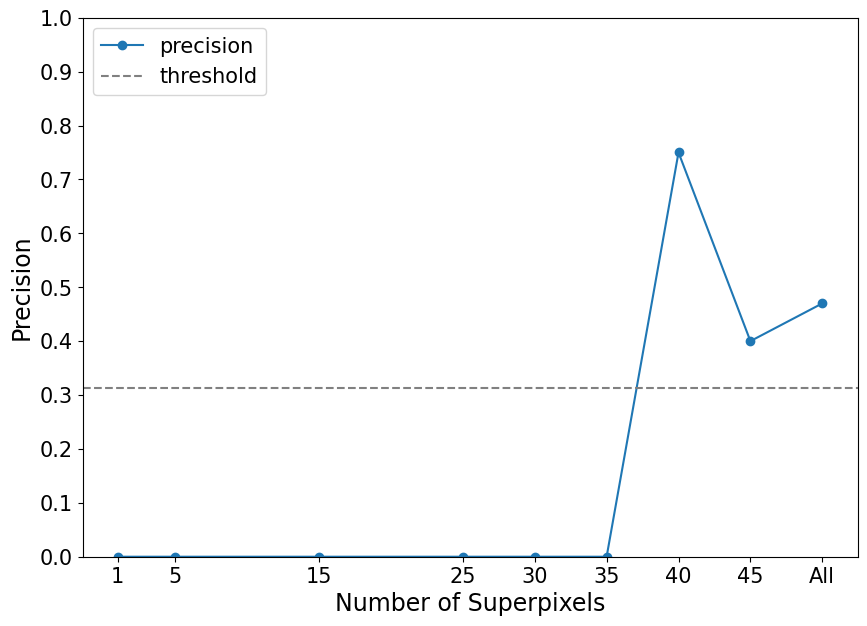

In [67]:
create_class_precision_graph("OTH", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of PEB Over the Number of Superpixels

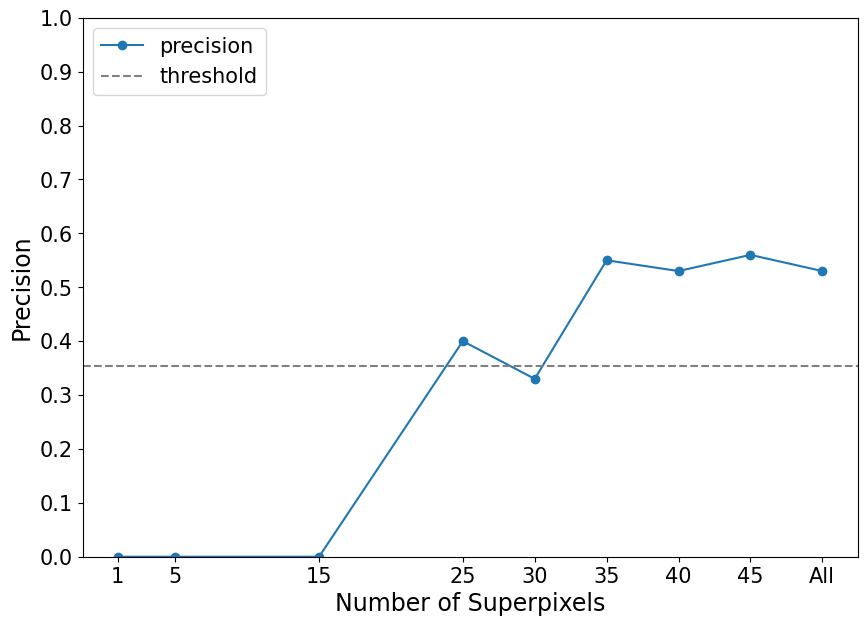

In [68]:
create_class_precision_graph("PEB", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of PLM Over the Number of Superpixels

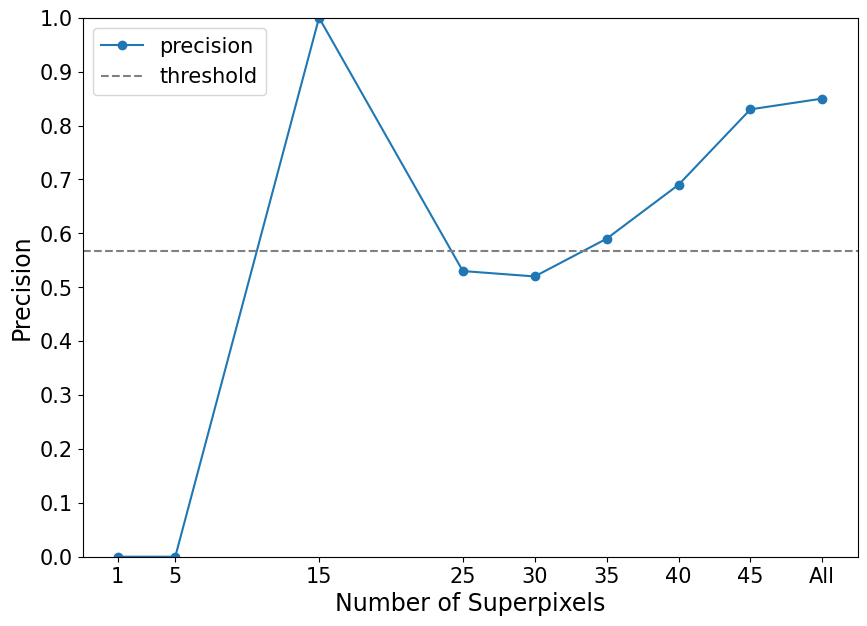

In [69]:
create_class_precision_graph("PLM", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)

## Precision of PMO Over the Number of Superpixels

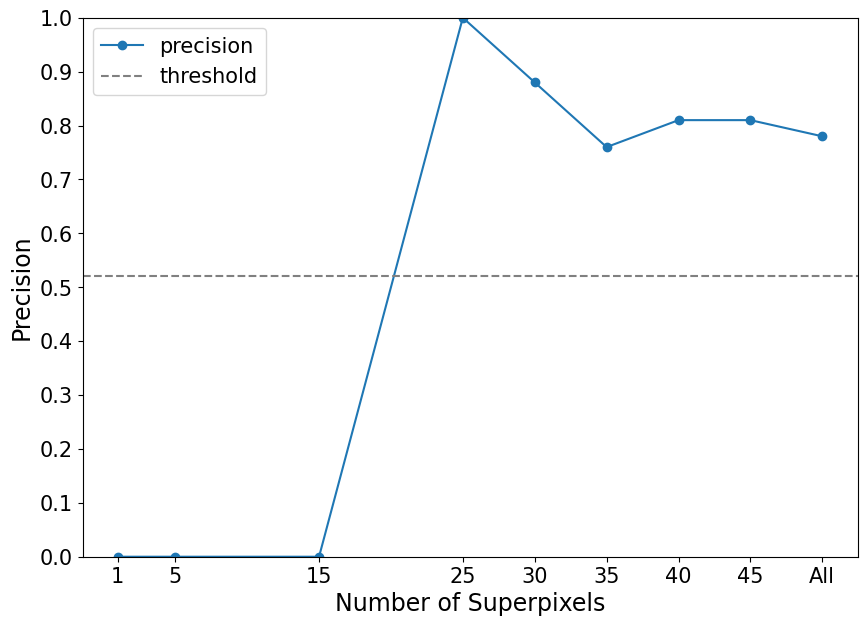

In [70]:
create_class_precision_graph("PMO", pre_dict1, pre_dict5, pre_dict15, pre_dict25, pre_dict30, pre_dict35, pre_dict40, pre_dict45, pre_dict_all)